In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import defaultdict
import scipy.stats
from scipy.spatial import distance
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
from sklearn.feature_extraction import _stop_words
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
import fasttext
import fasttext.util
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
def defaultdict_list():
    return defaultdict(list)

In [ ]:
# from formative 1
stops = list(_stop_words.ENGLISH_STOP_WORDS) + ['t', 's'] # Add 't' and 's' to stopwords

# Read in Data and Get Stats

In [ ]:
# Kaggle ArXiv Data

import os
import json

file_path = '~/Downloads/arxiv-metadata-oai-snapshot.json'

expanded_file_path = os.path.expanduser(file_path)



In [ ]:
import json

data = []
with open(expanded_file_path, 'r') as file:
    for line in file:
        json_object = json.loads(line)
        data.append(json_object)

In [ ]:
len(data)

2426574

In [ ]:
data_subset = [item for item in data if item['main_category'] in ['math', 'cs', 'physics']]

In [ ]:
len(data_subset)

1142849

## Update Data with Details

In [ ]:
# add year for each item in data
for item in data:
    created_date = item['versions'][0]['created']
    year = datetime.strptime(created_date, "%a, %d %b %Y %H:%M:%S %Z").year
    item['creation_year'] = year

In [ ]:
for item in data:
    item['team_size'] = len(item['authors'].split(','))

In [ ]:
# add main category and subcategory for each item
for item in data:
    main_subcategory = item['categories'].split()[0]
    parts = main_subcategory.split('.')
    main_category = parts[0]
    item['main_subcategory'] = main_subcategory
    item['main_category'] = main_category

In [ ]:
# # export updated data
# output_file_path = 'data/data.json'
# with open(output_file_path, 'w') as output_file:
#     json.dump(data, output_file)

In [ ]:
# read in data
import json
with open('../data/data.json') as file:
    data = json.load(file)

## Get Stats

In [ ]:
data_post_2000 = [item for item in data_subset if item['creation_year'] >= 2000]

In [ ]:
math_data = [item for item in data_post_2000 if item['main_category'] == 'math']

In [ ]:
len(math_data)

478301

In [ ]:
cs_data = [item for item in data_post_2000 if item['main_category'] == 'cs']

In [ ]:
len(cs_data)

484511

In [ ]:
physics_data = [item for item in data_post_2000 if item['main_category'] == 'physics']

In [ ]:
len(physics_data)

171280

In [ ]:
len(math_data) + len(cs_data) + len(physics_data)

1134092

In [ ]:
max([item['team_size'] for item in physics_data])

1324

In [ ]:
max([item['team_size'] for item in cs_data])

941

In [ ]:
max([item['team_size'] for item in math_data])

82

In [ ]:
physics_team_sizes = [item['team_size'] for item in physics_data]
physics_team_size_df = pd.DataFrame(physics_team_sizes, columns=['Team Size'])
physics_team_size_df.describe()

,Team Size
count,171280.000000
mean,4.897939
std,16.664049
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,1324.000000


In [ ]:
def get_descriptive_stats(team_sizes_df): 
    stats = team_sizes_df.describe()
    stats = stats.round(2)
    format_dict = {col: lambda x: f'{x:.2f}'.rstrip('0').rstrip('.') if pd.notna(x) else '' for col in stats.columns} # format numbers in  table
    latex_output = stats.to_latex(formatters=format_dict, index=True, caption="Descriptive Statistics of Team Sizes", label="tab:team_sizes")
    print(latex_output)
    return latex_output

In [ ]:
math_stats_latex = get_descriptive_stats(math_team_size_df)

\begin{table}
\caption{Descriptive Statistics of Team Sizes}
\label{tab:team_sizes}
\begin{tabular}{lr}
\toprule
 & Team Size \\
\midrule
count & 478301 \\
mean & 1.73 \\
std & 1.12 \\
min & 1 \\
25% & 1 \\
50% & 1 \\
75% & 2 \\
max & 82 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
cs_stats_latex = get_descriptive_stats(cs_team_size_df)

\begin{table}
\caption{Descriptive Statistics of Team Sizes}
\label{tab:team_sizes}
\begin{tabular}{lr}
\toprule
 & Team Size \\
\midrule
count & 484511 \\
mean & 3.53 \\
std & 3.4 \\
min & 1 \\
25% & 1 \\
50% & 3 \\
75% & 5 \\
max & 941 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
physics_stats_latex = get_descriptive_stats(physics_team_size_df)

\begin{table}
\caption{Descriptive Statistics of Team Sizes}
\label{tab:team_sizes}
\begin{tabular}{lr}
\toprule
 & Team Size \\
\midrule
count & 171280 \\
mean & 4.9 \\
std & 16.66 \\
min & 1 \\
25% & 1 \\
50% & 3 \\
75% & 5 \\
max & 1324 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
data_by_year = defaultdict(list)
for item in data:
    year = item['creation_year']
    data_by_year[year].append(item)

In [ ]:
data_years = set(data_by_year.keys())

# Preprocess Titles

In [ ]:
import re

def preprocess_title(title, remove_abbrev = True):
    title = title.lower()
    # Replace multiple spaces with single
    title = re.sub(r'\s+', ' ', title)
    # Remove punctuation except for hyphen
    title = re.sub(r'[^\w\s-]', '', title)
    
    # remove abbreviations in parentheses 
    if remove_abbrev: 
        title = re.sub(r'\(.*?\)', '', title)
    
    # Remove new lines
    title = title.replace('\n', '')
    
    tokens = word_tokenize(title)

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stops]
    filtered_title = ' '.join(filtered_tokens)
    
    return filtered_title.strip().split()

In [ ]:
# get list of unique preprocessed titles
unique_titles = set()
for item in data:
    title = item['title']
    preprocessed_title = preprocess_title(title)
    unique_titles.add(tuple(preprocessed_title))
    
unique_titles = [list(title) for title in unique_titles]


In [ ]:
# export as pickle
with open('unique_titles.pickle', 'wb') as f:
    pickle.dump(unique_titles, f)

In [ ]:
len(unique_titles)

2418317

## Title Lengths

In [ ]:
total_length = sum(len(title) for title in unique_titles)
average_length = total_length / len(unique_titles)
average_length


7.088771240494939

In [ ]:
title_lengths = [len(title) for title in unique_titles]
min_length = min(title_lengths)
max_length = max(title_lengths)
std_dev = np.std(title_lengths)

min_length, max_length, std_dev


(0, 39, 2.5583840170736236)

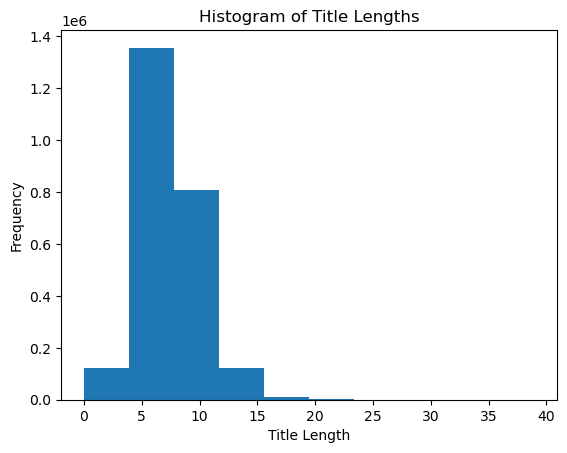

In [ ]:
import matplotlib.pyplot as plt

plt.hist(title_lengths, bins=10)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.show()


# Train FastText Model

In [ ]:
from gensim.models import fasttext as gensim_fasttext

In [ ]:
gs_ft_model = gensim_fasttext.load_facebook_model('model/pretrained/cc.en.300.bin')

In [ ]:
wiki_model = gensim_fasttext.load_facebook_model('model/pretrained/wiki/wiki.en.bin')

In [ ]:
class EpochLogger(CallbackAny2Vec):
    '''print after every 20 epochs'''
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        self.epoch += 1
        if self.epoch % 20 == 0:
            print('Epoch {}'.format(self.epoch))
            
def further_training(titles=unique_titles, pretrained_model = gs_ft_model, model_dir="model/further-trained", epochs=200, window_size = 15):
    '''
        Further train fastText model using paper titles
        --
        params
        --
        titles: cleaned unique titles
        pretrained_model: pre-trained fastText model to use
        model_dir: directory to save the trained model 
        epochs: # of epochs
        window_size: window size
    '''
    print("Load pretrained model")
    model = pretrained_model
    model.min_count = 0
    model.window = window_size
    
    epoch_logger = EpochLogger()
    
    print("Build vocab")
    model.build_vocab(unique_titles, update=True)
   
    model.train(
        corpus_iterable=unique_titles,
        total_examples=len(unique_titles),
        epochs=epochs,
        callbacks=[epoch_logger],
    )
    
    print("Model saving ")
    model.save(f'{model_dir}/base_{pretrained_model}_epoch{epochs}_window{window_size}.model')
    
# adapted from Jeon et al. (2023)

In [ ]:
# further training with large window size 
further_training(unique_titles, window_size = 2**30)

Load pretrained model
Build vocab
Model saving 


In [ ]:
# further training with window size 15
further_training(unique_titles, window_size=15)

Load pretrained model
Build vocab
Epoch 20
Epoch 40
Epoch 60
Epoch 80
Epoch 100
Epoch 120
Epoch 140
Epoch 160
Epoch 180
Epoch 200
Model saving 


In [ ]:
# further training wiki model
further_training(pretrained_model=wiki_model, titles = unique_titles, window_size=15, epochs = 100)

Load pretrained model
Build vocab
Epoch 20
Epoch 40
Epoch 60
Epoch 80
Epoch 100
Model saving 


In [ ]:
further_trained_wiki_model = FastText.load('model/further-trained/base_FastText<vocab=2929030, vector_size=300, alpha=0.025>_epoch100_window15.model')

In [ ]:
further_trained_cc_en_w15 = FastText.load('model/further-trained/epoch200_window15.model')

In [ ]:
further_trained_cc_en = FastText.load('model/further-trained/epoch200.model')

## Get Number of Missing Vectors per Model

In [ ]:
def get_num_missing_embeddings(model, titles):
    counter = 0
    for doc in tqdm(titles):
        for k in doc: 
            if not model.wv.has_index_for(k): 
                counter += 1
    return counter
            
        

In [ ]:
get_num_missing_embeddings(wiki_model, unique_titles)

  0%|          | 0/2418317 [00:00<?, ?it/s]100%|██████████| 2418317/2418317 [00:07<00:00, 341531.60it/s]


2005276

In [ ]:
get_num_missing_embeddings(gs_ft_model, unique_titles)

100%|██████████| 2418317/2418317 [00:06<00:00, 358492.68it/s]


1445157

In [ ]:

total_words = 0
for title in unique_titles:
    for word in title:
        total_words += 1

print("Total number of words in unique_titles:", total_words)


Total number of words in unique_titles: 17142896


In [ ]:
# get unique words
unique_words = set()

for title in unique_titles:
    for word in title:
        unique_words.update(word)


In [ ]:
len(unique_words)

39

In [ ]:
# missing unique words in wiki
wiki_counter = 0
for word in unique_words:
    if not wiki_model.wv.has_index_for(word): 
         wiki_counter += 1
         
print(wiki_counter)

10


In [ ]:
# missing unique words in cc wiki
cc_counter = 0
for word in unique_words:
    if not gs_ft_model.wv.has_index_for(word): 
         cc_counter += 1
         
print(cc_counter)

1


# Validate Trained Embeddings

In [ ]:
from numpy import dot
from numpy.linalg import norm


def title_words_avg_distance(model, titles):
    '''
        Get avg pairwise cosine similarity between words in a title using given model
    '''
    def cos_sim(v1, v2): 
        # function to get cosine similarity
        norm_v1, norm_v2 = norm(v1), norm(v2)
        # check for zero division
        if norm_v1 == 0 or norm_v2 == 0:
            print("norm_v1 == 0 or norm_v2 == 0")
            return float('nan')
        return dot(v1, v2) / (norm_v1 * norm_v2)

    average_similarities = []
    for title in tqdm(titles):
        # titles is list of lists w/ words in each title
        # title is list of words in one title
        # skip one-word titles
        if len(title) < 2: continue
        # get vector for each word in title
        vectors = [model.wv[k] for k in title]
        if len(vectors) < 2: continue

        total = []
        for i, v1 in enumerate(vectors):
            for j, v2 in enumerate(vectors):
                # only calculate once
                if i >= j: continue
                similarity = cos_sim(v1, v2)
                if not np.isnan(similarity):
                    total.append(similarity)
                else: 
                    print(f"similarity is nan for {v1}, {v2}")
        if total: 
            #  get average similarity for title
            avg_sim = sum(total) / len(total)
            # add to list of avg similarities
            average_similarities.append(avg_sim)
    # remove any nans
    average_similarities = [similarity for similarity in average_similarities if not np.isnan(similarity)]
    if average_similarities: 
        # get average
        avg_all = sum(average_similarities) / len(average_similarities)
    else:
        print("average_similarities is empty")
        avg_all = float('nan')
    
    return avg_all

# adapted from Jeon et al. (2023) 

## Pre-trained Model Distance

In [ ]:
avg_dist_pretrained_wiki = title_words_avg_distance(wiki_model, unique_titles)
print(avg_dist_pretrained_wiki)

100%|██████████| 2418317/2418317 [05:23<00:00, 7468.14it/s]


0.2719095709858948


In [ ]:
avg_dist_pretrained_cc = title_words_avg_distance(gs_ft_model, unique_titles)
print(avg_dist_pretrained_cc)

100%|██████████| 2418317/2418317 [06:02<00:00, 6662.76it/s]


0.18667246933602194


## Further Trained Model Distance

In [ ]:
avg_dist_further_wiki = title_words_avg_distance(further_trained_wiki_model, unique_titles)
avg_dist_further_wiki

100%|██████████| 2418317/2418317 [04:21<00:00, 9257.48it/s] 


0.3228797110026573

In [ ]:
avg_dist_further_cc_en_w15 = title_words_avg_distance(further_trained_cc_en_w15, unique_titles)
avg_dist_further_cc_en_w15

100%|██████████| 2418317/2418317 [08:02<00:00, 5013.39it/s]


0.5393399469509679

In [ ]:
avg_dist_further_cc_en = title_words_avg_distance(further_trained_cc_en, unique_titles)
avg_dist_further_cc_en 

100%|██████████| 2418317/2418317 [09:34<00:00, 4207.28it/s]


0.5078598911778051

## Distances Table

In [ ]:
model_avg_distances = defaultdict(float)
model_avg_distances['pretrained_wiki'] = avg_dist_pretrained_wiki
model_avg_distances['pretrained_cc'] = avg_dist_pretrained_cc
model_avg_distances['further_wiki'] = avg_dist_further_wiki
model_avg_distances['further_cc_15'] = avg_dist_further_cc_en_w15
model_avg_distances['further_cc'] = avg_dist_further_cc_en 

In [ ]:
model_avg_distances_df = pd.DataFrame.from_dict(model_avg_distances, orient='index', columns=['Average Distance'])
model_avg_distances_df.index.name = 'Model'

In [ ]:
model_avg_distances_df

,Average Distance
Model,
pretrained_wiki,0.271910
pretrained_cc,0.186672
further_wiki,0.322880
further_cc_15,0.539340
further_cc,0.507860


In [ ]:
print(model_avg_distances_df.to_latex())

\begin{tabular}{lr}
\toprule
 & Average Distance \\
Model &  \\
\midrule
pretrained_wiki & 0.271910 \\
pretrained_cc & 0.186672 \\
further_wiki & 0.322880 \\
further_cc_15 & 0.539340 \\
further_cc & 0.507860 \\
\bottomrule
\end{tabular}



# Get Vector for Every Title in Dataset

In [ ]:
def title_to_vector_ft(title, model):
    ''' get the vector for a title'''
    words = title
    # get word vector depending on fasttext or gensim package
    if hasattr(model, 'get_word_vector'):
        word_vectors = [model.get_word_vector(word) for word in words]
        if not words:
            return np.zeros(model.get_dimension())
    else:
        if not words:
            return np.zeros(model.wv.vector_size)
        word_vectors = [model.wv[word] for word in words]
    # get title vector as mean of word vectors
    title_vector = np.mean(word_vectors, axis = 0)
    return title_vector

In [ ]:
# get dict of title ids and vectors
id_to_vector = {}
for item in tqdm(data_subset):
    preprocessed_title = preprocess_title(item['title'])
    title_vector = title_to_vector_ft(preprocessed_title, model = further_trained_cc_en_w15)
    id_to_vector[item['id']] = title_vector



100%|██████████| 1142849/1142849 [01:48<00:00, 10531.65it/s]


# Get Vectors by Category and Subcategory

In [ ]:
def get_category_vectors(data):
    ''' get a vector for each title per category and subcategory'''    
    category_vectors = defaultdict(list)
    subcategory_vectors = defaultdict(defaultdict_list)
    for title_info in data:
        title_id = title_info['id']
        main_subcategory = title_info['main_subcategory']
        main_category = title_info['main_category']
        title_vector = id_to_vector[title_id]
        category_vectors[main_category].append((title_id, title_vector))
        subcategory_vectors[main_category][main_subcategory].append((title_id, title_vector))
    return category_vectors, subcategory_vectors


In [ ]:
category_vectors, subcategory_vectors = get_category_vectors(data)

In [ ]:
def get_cat_year_vectors(data):
    ''' get a vector for each title per category and year'''
    category_year_vectors = defaultdict(defaultdict_list)
    for title_info in tqdm(data):
        title_id = title_info['id']
        # main_subcategory = title_info['main_subcategory']
        main_category = title_info['main_category']
        year = title_info['creation_year']
        title_vector = id_to_vector[title_id]
        category_year_vectors[main_category][year].append(title_vector)
    return category_year_vectors


In [ ]:
category_year_vectors = get_cat_year_vectors(data)

 20%|█▉        | 474813/2426574 [00:00<00:01, 1555194.76it/s]100%|██████████| 2426574/2426574 [00:21<00:00, 115015.71it/s]


In [ ]:
def get_subcat_year_vectors(data):
    ''' returns dictionaries with keys: 
    category, subcategory, year
    category, subcategory, team_type, year
    category, subcategory, team_size, year
    and values: vectors'''
    subcat_year_vectors = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    subcat_team_type_vectors = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
    subcat_team_size_vectors = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
    for title_info in tqdm(data):
        title_id = title_info['id']
        # main_subcategory = title_info['main_subcategory']
        main_category = title_info['main_category']
        subcategory = title_info['main_subcategory']
        year = title_info['creation_year']
        team_size = title_info['team_size']
        if team_size == 0:
            continue
        # get team type
        team_type = 'single' if team_size == 1 else 'team'
        title_vector = id_to_vector[title_id]
        subcat_year_vectors[main_category][subcategory][year].append(title_vector)
        subcat_team_type_vectors[main_category][subcategory][team_type][year].append(title_vector)
        subcat_team_size_vectors[main_category][subcategory][team_size][year].append(title_vector)
    return subcat_year_vectors, subcat_team_type_vectors, subcat_team_size_vectors

In [ ]:
subcat_year_vectors, subcat_team_type_vectors, subcat_team_size_vectors = get_subcat_year_vectors(data_subset)

100%|██████████| 1142849/1142849 [00:06<00:00, 175353.92it/s]


# Centroids

In [ ]:
def defaultdict_of_defaultdicts():
    return defaultdict(lambda: defaultdict(list))

In [ ]:
def get_cumulative_subcat_centroids(subcat_year_vectors):
    ''' get cumulative centroids up to present year for each subcat '''
    cumulative_centroids = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    for cat in tqdm(subcat_year_vectors):
        for subcat in subcat_year_vectors[cat]:
            # list for all vectors up to given year
            cumulative_vectors = [] 
            for year in sorted(subcat_year_vectors[cat][subcat].keys()):
                # Extend list with vectors from current year
                cumulative_vectors.extend(subcat_year_vectors[cat][subcat][year])
                if cumulative_vectors:
                    # get centroid as mean of all title vectors
                    cumulative_centroids[cat][subcat][year] = np.mean(cumulative_vectors, axis=0)
    
    return cumulative_centroids

cumulative_subcat_centroids = get_cumulative_subcat_centroids(subcat_year_vectors)

100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


# Subfield Distances

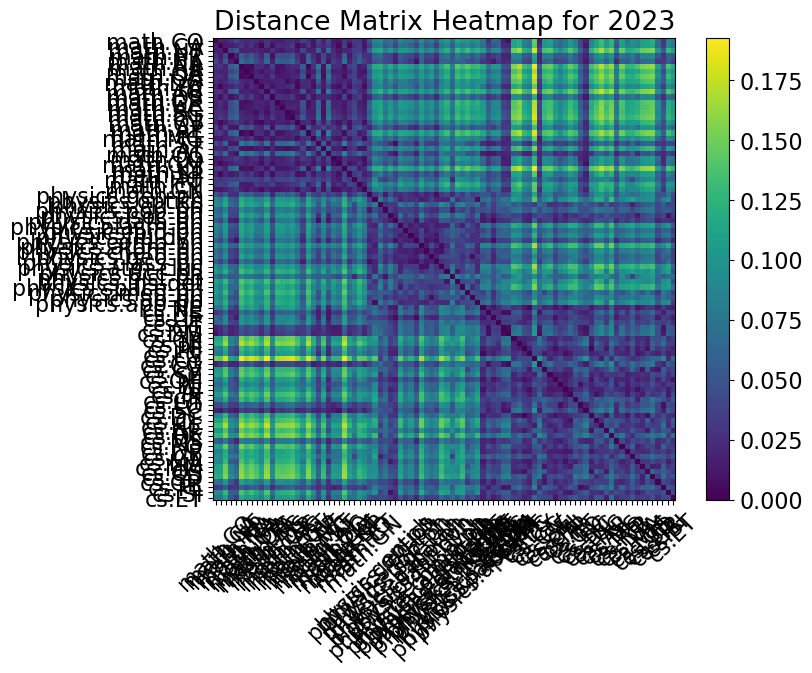

In [ ]:
# check distance between subfields in 2023
from scipy.spatial.distance import cosine
# Filter cumulative_subcat_centroids for 2023
filtered_centroids = {}
for cat in cumulative_subcat_centroids:
    for subcat in cumulative_subcat_centroids[cat]:
        if 2023 in cumulative_subcat_centroids[cat][subcat]:
            filtered_centroids[subcat] = cumulative_subcat_centroids[cat][subcat][2023]

# get list of subfields
subfields = list(filtered_centroids.keys())
# initialize matrix for distances using length of subfields
distance_matrix = np.zeros((len(subfields), len(subfields)))

for i, subfield1 in enumerate(subfields):
    for j, subfield2 in enumerate(subfields):
        # get cosine distance between two subfields
        distance_matrix[i, j] = cosine(filtered_centroids[subfield1], filtered_centroids[subfield2])

# plot heat map of distances
plt.figure(figsize=(8, 6))
plt.imshow(distance_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(ticks=np.arange(len(subfields)), labels=subfields, rotation=45)
plt.yticks(ticks=np.arange(len(subfields)), labels=subfields)
plt.title('Distance Matrix Heatmap for 2023')
plt.show()

In [ ]:
len(cumulative_subcat_centroids['math'])

30

In [ ]:
len(cumulative_subcat_centroids['cs'])

40

In [ ]:
len(cumulative_subcat_centroids['physics'])

22

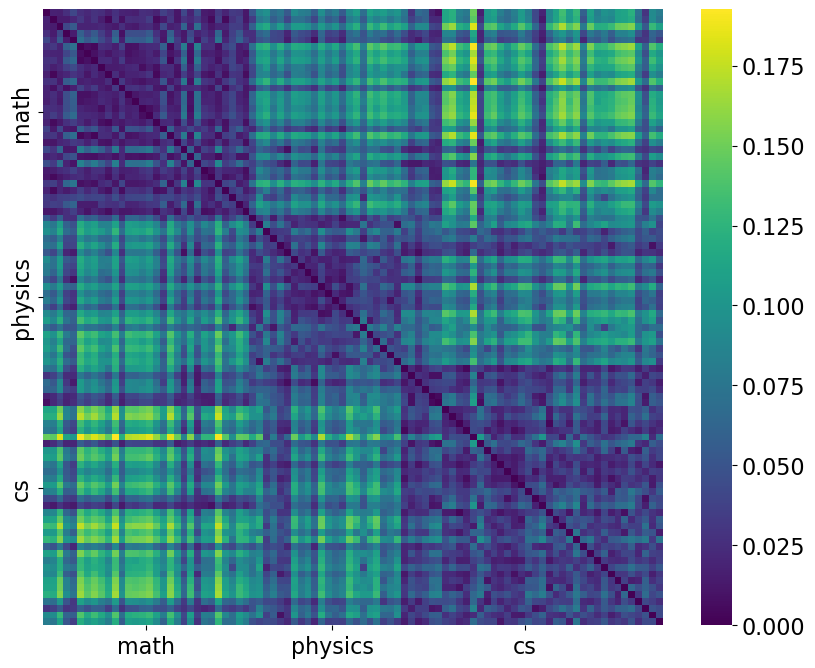

In [ ]:
# update heatmap with just category labels
# set positions for each category
categories = {'math': (15, 29), 'physics': (42, 69), 'cs': (70, 91)}
labels = [''] * 90 
for category, (start, end) in categories.items():
    labels[start] = category # category label at start position

plt.figure(figsize=(10, 8))
ax = sns.heatmap(distance_matrix, cmap='viridis', xticklabels=labels, yticklabels=labels)
# set ticks and labels at specified label locations
ax.set_xticks([i for i, label in enumerate(labels) if label]) 
ax.set_yticks([i for i, label in enumerate(labels) if label])
ax.set_xticklabels([label for label in labels if label])
ax.set_yticklabels([label for label in labels if label])
plt.show()

In [ ]:
len(cumulative_subcat_centroids['math'])

30

In [ ]:
len(cumulative_subcat_centroids['cs'])

40

In [ ]:
len(cumulative_subcat_centroids['physics'])

22

 rerun with baseline fasttext model

In [ ]:
# # get dict of title ids and vectors
# id_to_vector = {}
# for item in tqdm(data_subset):
#     preprocessed_title = preprocess_title(item['title'])
#     title_vector = title_to_vector_ft(preprocessed_title, model = gs_ft_model)
#     id_to_vector[item['id']] = title_vector



100%|██████████| 1142849/1142849 [02:47<00:00, 6820.53it/s]


In [ ]:
subcat_year_vectors, subcat_team_type_vectors, subcat_team_size_vectors = get_subcat_year_vectors(data_subset)

In [ ]:
cumulative_subcat_centroids = get_cumulative_subcat_centroids(subcat_year_vectors)

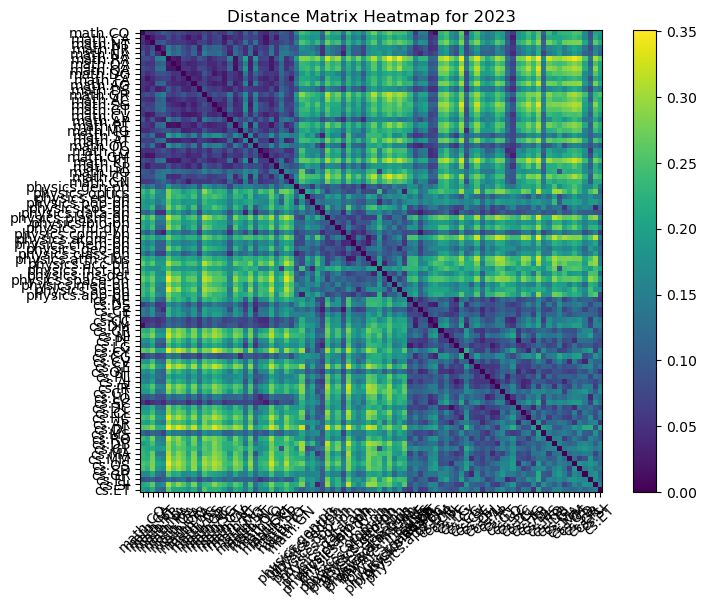

In [ ]:
# check distance between subfields in 2023
from scipy.spatial.distance import cosine
# Filter cumulative_subcat_centroids for 2023
filtered_centroids = {}
for cat in cumulative_subcat_centroids:
    for subcat in cumulative_subcat_centroids[cat]:
        if 2023 in cumulative_subcat_centroids[cat][subcat]:
            filtered_centroids[subcat] = cumulative_subcat_centroids[cat][subcat][2023]

# get list of subfields
subfields = list(filtered_centroids.keys())
# initialize matrix for distances using length of subfields
distance_matrix = np.zeros((len(subfields), len(subfields)))

for i, subfield1 in enumerate(subfields):
    for j, subfield2 in enumerate(subfields):
        # get cosine distance between two subfields
        distance_matrix[i, j] = cosine(filtered_centroids[subfield1], filtered_centroids[subfield2])

# plot heat map of distances
plt.figure(figsize=(8, 6))
plt.imshow(distance_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(ticks=np.arange(len(subfields)), labels=subfields, rotation=45)
plt.yticks(ticks=np.arange(len(subfields)), labels=subfields)
plt.title('Distance Matrix Heatmap for 2023')
plt.show()

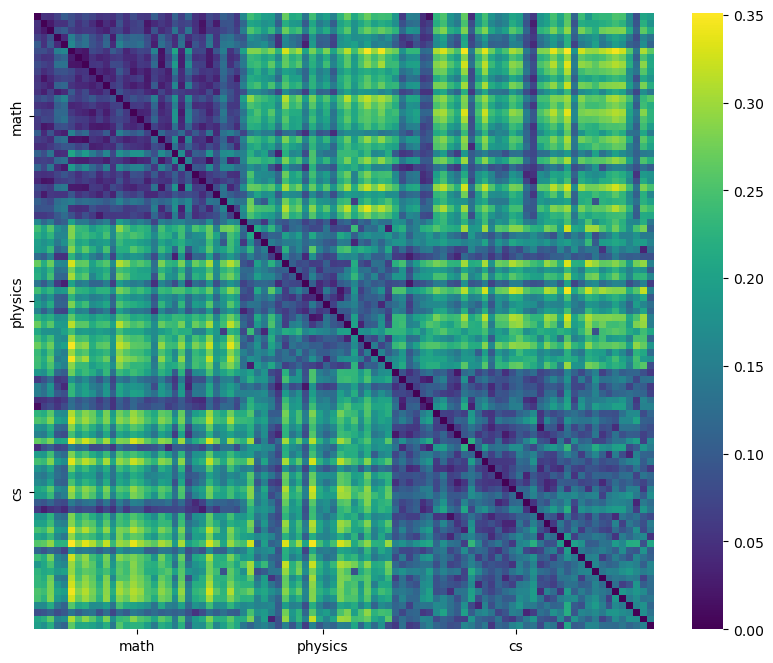

In [ ]:
# update heatmap with just category labels
# set positions for each category
import seaborn as sns
categories = {'math': (15, 29), 'physics': (42, 69), 'cs': (70, 91)}
labels = [''] * 90 
for category, (start, end) in categories.items():
    labels[start] = category # category label at start position

plt.figure(figsize=(10, 8))
ax = sns.heatmap(distance_matrix, cmap='viridis', xticklabels=labels, yticklabels=labels)
# set ticks and labels at specified label locations
ax.set_xticks([i for i, label in enumerate(labels) if label]) 
ax.set_yticks([i for i, label in enumerate(labels) if label])
ax.set_xticklabels([label for label in labels if label])
ax.set_yticklabels([label for label in labels if label])
plt.show()

# Cosine Similarities

# By Year

In [ ]:
def get_cosine_similarities_time(category, cat_vectors, centroids):
    ''' get cosine similarities by subcategory, team type, and year'''
    cosine_similarities_time = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    cat_vectors = cat_vectors[category]
    for subcategory, details in tqdm(cat_vectors.items()):
        for team_type, year_vectors in details.items():
            # Compute similarities by year
            for year, vectors in year_vectors.items():
                centroid = centroids[category][subcategory][year]
                for vector in vectors: 
                    try: 
                        sim = 1 - distance.cosine(centroid, vector)
                        cosine_similarities_time[subcategory][team_type][year].append(sim)
                    except ValueError: 
                        print(ValueError)
                        continue


    return cosine_similarities_time



Cosine similarities by team size

In [ ]:
math_cosine_similarities_team_size = get_cosine_similarities_time('math', subcat_team_size_vectors, cumulative_subcat_centroids)

In [ ]:
cs_cosine_similarities_team_size = get_cosine_similarities_time('cs', subcat_team_size_vectors, cumulative_subcat_centroids)

In [ ]:
physics_cosine_similarities_team_size = get_cosine_similarities_time('physics', subcat_team_size_vectors, cumulative_subcat_centroids)

Cosine similarities by team type

In [ ]:
math_cosine_similarities = get_cosine_similarities_time('math', subcat_team_type_vectors, cumulative_subcat_centroids)

In [ ]:
cs_cosine_similarities = get_cosine_similarities_time('cs', subcat_team_type_vectors, cumulative_subcat_centroids)

In [ ]:
physics_cosine_similarities = get_cosine_similarities_time('physics', subcat_team_type_vectors, cumulative_subcat_centroids)

## Average Yearly Similarities

In [ ]:
def get_average_similarities(cosine_similarities):
    '''get avg similarities by subcat, team type, year'''
    average_cosine_similarities = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    for subcategory, team_types in cosine_similarities.items():
        for team_type, years in team_types.items():
            for year, similarities in years.items():
                if similarities:  
                    average = sum(similarities) / len(similarities)
                else:
                    # avoid divide by zero
                    average = float('nan')

                average_cosine_similarities[subcategory][team_type][year] = average
    return average_cosine_similarities

In [ ]:
math_avg_similarities = get_average_similarities(math_cosine_similarities)

In [ ]:
cs_avg_similarities = get_average_similarities(cs_cosine_similarities)

In [ ]:
physics_avg_similarities = get_average_similarities(physics_cosine_similarities)

## Correlations

In [ ]:
# get correlations on individual paper level for each subcategory
from scipy.stats import pearsonr
from scipy.stats import spearmanr


def get_individual_correlations(cosine_similarities_time, start_year = 2019, end_year = 2023):
    '''get correlations of team size to cosine similarity for past 5 years'''
    correlations_individual = {}
    for subcategory, team_sizes in cosine_similarities_time.items():
        all_team_sizes = []
        all_cosine_similarities = []

        for team_size, years in team_sizes.items():
            for year, similarities in years.items():
                # get similarities within last 5 years
                if start_year <= year <= end_year:
                    all_team_sizes.extend([team_size] * len(similarities))  # store time size
                    all_cosine_similarities.extend(similarities)  # store similarlities

        # Calculate correlation for each subcategory between team size and cosine similarity
        if all_team_sizes and all_cosine_similarities:
            correlation, p_value = spearmanr(all_team_sizes, all_cosine_similarities)
            correlations_individual[subcategory] = (correlation, p_value)
        else:
            correlations_individual[subcategory] = None

    for subcategory, (correlation, p_value) in correlations_individual.items():
        if correlation is not None:
            print(f"{subcategory}: Correlation between team size and cosine similarity (individual points) = {correlation:.4f}, p-value: {p_value}")
        else:
            print(f"{subcategory}: No data for correlation")
    return correlations_individual


In [ ]:
math_correlations = get_individual_correlations(math_cosine_similarities_team_size)

In [ ]:
cs_correlations = get_individual_correlations(cs_cosine_similarities_team_size)

cs.NE: Correlation between team size and cosine similarity (individual points) = 0.0336, p-value: 0.0490510504713616
cs.DS: Correlation between team size and cosine similarity (individual points) = 0.0103, p-value: 0.4030620275244472
cs.CE: Correlation between team size and cosine similarity (individual points) = -0.0894, p-value: 0.00011081527464632297
cs.IT: Correlation between team size and cosine similarity (individual points) = 0.0103, p-value: 0.25718109843854436
cs.CC: Correlation between team size and cosine similarity (individual points) = 0.0258, p-value: 0.2913640749697718
cs.DM: Correlation between team size and cosine similarity (individual points) = 0.0168, p-value: 0.5362637599433949
cs.CR: Correlation between team size and cosine similarity (individual points) = 0.0439, p-value: 5.074836630129834e-07
cs.NI: Correlation between team size and cosine similarity (individual points) = -0.0181, p-value: 0.1407223181069198
cs.PF: Correlation between team size and cosine simila

In [ ]:
physics_correlations = get_individual_correlations(physics_cosine_similarities_team_size)

physics.gen-ph: Correlation between team size and cosine similarity (individual points) = 0.0098, p-value: 0.7043937554060712
physics.optics: Correlation between team size and cosine similarity (individual points) = -0.1178, p-value: 6.545105007790483e-37
physics.ed-ph: Correlation between team size and cosine similarity (individual points) = 0.0746, p-value: 0.01287836265457358
physics.pop-ph: Correlation between team size and cosine similarity (individual points) = -0.0019, p-value: 0.9686209343789514
physics.soc-ph: Correlation between team size and cosine similarity (individual points) = -0.0348, p-value: 0.01764164398572856
physics.data-an: Correlation between team size and cosine similarity (individual points) = -0.0044, p-value: 0.9046322814657032
physics.plasm-ph: Correlation between team size and cosine similarity (individual points) = -0.0867, p-value: 2.772773134439401e-08
physics.bio-ph: Correlation between team size and cosine similarity (individual points) = -0.0527, p-va

In [ ]:
# get table of correlations
physics_corr_df = pd.DataFrame(physics_correlations).T

physics_corr_df = physics_corr_df.rename(columns = {0: 'Correlation', 1: 'p-value'})

physics_corr_df['Correlation'] = physics_corr_df['Correlation'].map('{:.2f}'.format)
physics_corr_df['p-value'] = physics_corr_df['p-value'].map('{:.2f}'.format)
physics_corr_df

,Correlation,p-value
physics.gen-ph,0.01,0.70
physics.optics,-0.12,0.00
physics.ed-ph,0.07,0.01
physics.pop-ph,-0.00,0.97
physics.soc-ph,-0.03,0.02
physics.data-an,-0.00,0.90
physics.plasm-ph,-0.09,0.00
physics.bio-ph,-0.05,0.02
physics.flu-dyn,-0.07,0.00
physics.comp-ph,-0.07,0.00


In [ ]:
math_corr_df = pd.DataFrame(math_correlations).T


math_corr_df = math_corr_df.rename(columns = {0: 'Correlation', 1: 'p-value'})


math_corr_df['Correlation'] = math_corr_df['Correlation'].map('{:.2f}'.format)
math_corr_df['p-value'] = math_corr_df['p-value'].map('{:.2f}'.format)
math_corr_df

,Correlation,p-value
math.CO,0.02,0.01
math.CA,0.01,0.60
math.NT,0.01,0.50
math.PR,0.01,0.49
math.NA,-0.02,0.03
math.RA,0.02,0.22
math.OA,-0.03,0.19
math.QA,-0.00,0.97
math.DG,0.01,0.34
math.FA,-0.00,0.85


In [ ]:
cs_corr_df = pd.DataFrame(cs_correlations).T


cs_corr_df = cs_corr_df.rename(columns = {0: 'Correlation', 1: 'p-value'})


cs_corr_df['Correlation'] = cs_corr_df['Correlation'].map('{:.2f}'.format)
cs_corr_df['p-value'] = cs_corr_df['p-value'].map('{:.2f}'.format)
cs_corr_df

,Correlation,p-value
cs.NE,0.03,0.05
cs.DS,0.01,0.40
cs.CE,-0.09,0.00
cs.IT,0.01,0.26
cs.CC,0.03,0.29
cs.DM,0.02,0.54
cs.CR,0.04,0.00
cs.NI,-0.02,0.14
cs.PF,0.03,0.48
cs.LG,-0.03,0.00


In [ ]:
# format significance for table
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

math_corr_df['p-value'] = pd.to_numeric(math_corr_df['p-value'], errors='coerce') 
math_corr_df['Significance'] = math_corr_df['p-value'].apply(significance_stars)
math_corr_df['Correlation_Significance'] = math_corr_df['Correlation'].astype(str) + math_corr_df['Significance']



In [ ]:
math_corr_df.drop(['Correlation', 'p-value', 'Significance'], axis=1, inplace=True)

math_corr_df

,Correlation_Significance
math.CO,0.02*
math.CA,0.01
math.NT,0.01
math.PR,0.01
math.NA,-0.02*
math.RA,0.02
math.OA,-0.03
math.QA,-0.00
math.DG,0.01
math.FA,-0.00


In [ ]:
print(math_corr_df.to_latex(index=True, escape=False))

\begin{tabular}{ll}
\toprule
 & Correlation_Significance \\
\midrule
math.CO & 0.02* \\
math.CA & 0.01 \\
math.NT & 0.01 \\
math.PR & 0.01 \\
math.NA & -0.02* \\
math.RA & 0.02 \\
math.OA & -0.03 \\
math.QA & -0.00 \\
math.DG & 0.01 \\
math.FA & -0.00 \\
math.AG & -0.01 \\
math.DS & -0.03* \\
math.GR & -0.01 \\
math.AC & -0.01 \\
math.SG & 0.03 \\
math.GT & 0.00 \\
math.CV & 0.01 \\
math.AP & -0.02* \\
math.RT & 0.02 \\
math.MG & 0.02 \\
math.ST & 0.00 \\
math.AT & -0.03 \\
math.OC & -0.03*** \\
math.LO & 0.01 \\
math.GM & 0.07*** \\
math.KT & 0.02 \\
math.SP & -0.04 \\
math.HO & -0.04 \\
math.CT & -0.03 \\
math.GN & 0.02 \\
\bottomrule
\end{tabular}



In [ ]:
cs_corr_df['p-value'] = pd.to_numeric(cs_corr_df['p-value'], errors='coerce') 
cs_corr_df['Significance'] = cs_corr_df['p-value'].apply(significance_stars)
cs_corr_df['Correlation_Significance'] = cs_corr_df['Correlation'].astype(str) + cs_corr_df['Significance']
cs_corr_df.drop(['Correlation', 'p-value', 'Significance'], axis=1, inplace=True)
print(cs_corr_df.to_latex(index=True, escape=False))


\begin{tabular}{ll}
\toprule
 & Correlation_Significance \\
\midrule
cs.NE & 0.03 \\
cs.DS & 0.01 \\
cs.CE & -0.09*** \\
cs.IT & 0.01 \\
cs.CC & 0.03 \\
cs.DM & 0.02 \\
cs.CR & 0.04*** \\
cs.NI & -0.02 \\
cs.PF & 0.03 \\
cs.LG & -0.03*** \\
cs.CY & 0.03* \\
cs.CG & 0.01 \\
cs.CV & -0.05*** \\
cs.SE & -0.02 \\
cs.OH & 0.05 \\
cs.PL & 0.04 \\
cs.AI & 0.01 \\
cs.IR & 0.08*** \\
cs.GT & 0.02 \\
cs.LO & 0.00 \\
cs.SC & 0.04 \\
cs.DC & 0.00 \\
cs.CL & 0.02*** \\
cs.HC & 0.02 \\
cs.AR & -0.00 \\
cs.DL & 0.05 \\
cs.MS & 0.05 \\
cs.RO & -0.05*** \\
cs.DB & -0.00 \\
cs.GL & 0.05 \\
cs.MA & 0.06* \\
cs.MM & -0.00 \\
cs.OS & 0.10 \\
cs.NA & -0.06 \\
cs.SD & -0.01 \\
cs.GR & 0.05 \\
cs.FL & -0.02 \\
cs.SI & -0.05*** \\
cs.SY & 0.05 \\
cs.ET & 0.07* \\
\bottomrule
\end{tabular}



In [ ]:
physics_corr_df['p-value'] = pd.to_numeric(physics_corr_df['p-value'], errors='coerce') 
physics_corr_df['Significance'] = physics_corr_df['p-value'].apply(significance_stars)
physics_corr_df['Correlation_Significance'] = physics_corr_df['Correlation'].astype(str) + physics_corr_df['Significance']
physics_corr_df.drop(['Correlation', 'p-value', 'Significance'], axis=1, inplace=True)
print(physics_corr_df.to_latex(index=True, escape=False))


\begin{tabular}{ll}
\toprule
 & Correlation_Significance \\
\midrule
physics.gen-ph & 0.01 \\
physics.optics & -0.12*** \\
physics.ed-ph & 0.07* \\
physics.pop-ph & -0.00 \\
physics.soc-ph & -0.03* \\
physics.data-an & -0.00 \\
physics.plasm-ph & -0.09*** \\
physics.bio-ph & -0.05* \\
physics.flu-dyn & -0.07*** \\
physics.comp-ph & -0.07*** \\
physics.atom-ph & -0.05* \\
physics.chem-ph & -0.14*** \\
physics.geo-ph & -0.06* \\
physics.class-ph & 0.07* \\
physics.atm-clus & -0.05 \\
physics.acc-ph & -0.09*** \\
physics.hist-ph & -0.06 \\
physics.ins-det & -0.03* \\
physics.space-ph & 0.07* \\
physics.med-ph & -0.08*** \\
physics.ao-ph & -0.08*** \\
physics.app-ph & -0.08*** \\
\bottomrule
\end{tabular}



## Ratio: Relative Team Similarity

In [ ]:
def get_ratios(average_similarities):
    ''' get ratio of team to individual cosine similarities 
    returns dictionary ratios[subcategory][year] = ratio'''
    ratios = defaultdict(lambda: defaultdict(float))
    for subcategory, team_types in average_similarities.items():
        for year in team_types['team']:
            if year in team_types['single'] and team_types['single'][year] != 0:
                # get avg similarity for team and solo
                team_avg = team_types['team'][year]
                solo_avg = team_types['single'][year]
                # get ratio
                ratios[subcategory][year] = team_avg / solo_avg
    return ratios


In [ ]:
math_ratios = get_ratios(math_avg_similarities)

In [ ]:
def get_ratio_year(subcategory_ratios, target_year):
    ratio_year = {}
    for subcategory, years in subcategory_ratios.items():
        if target_year in years:
            ratio_year[subcategory] = years[2023]
    return ratio_year

In [ ]:
math_ratios_2023 = get_ratio_year(math_ratios)

In [ ]:
math_ratios_2023

{'math.CO': 1.007395494445497,
 'math.CA': 1.009901838769263,
 'math.NT': 1.0042538564724754,
 'math.PR': 1.0019068501785218,
 'math.NA': 1.0034502747232144,
 'math.RA': 1.014968685285601,
 'math.OA': 1.0123473062743304,
 'math.QA': 1.0014173349054052,
 'math.DG': 1.0035284846814305,
 'math.FA': 1.005374090671116,
 'math.AG': 1.0081059800962782,
 'math.DS': 0.9992871773517195,
 'math.GR': 1.0044825065136884,
 'math.AC': 1.0104895053169394,
 'math.SG': 1.0059356887078097,
 'math.GT': 0.9970085627343439,
 'math.CV': 1.0039801585500425,
 'math.AP': 0.9999117912214974,
 'math.RT': 1.0008419388982956,
 'math.MG': 1.0249683811960724,
 'math.ST': 1.0027418231323955,
 'math.AT': 1.0020340183706689,
 'math.OC': 1.0006288868382158,
 'math.LO': 1.0073075341932254,
 'math.GM': 1.0064558015807579,
 'math.KT': 1.015005213435258,
 'math.SP': 1.004703217640821,
 'math.HO': 0.9108894227508463,
 'math.CT': 0.9985879458202254,
 'math.GN': 0.9933966751377529}

In [ ]:
cs_ratios = get_ratios(cs_avg_similarities)

In [ ]:
physics_ratios = get_ratios(physics_avg_similarities)

## Ratio Subcategory Plots

In [ ]:
import matplotlib.pyplot as plt

def plot_ratios(ratios, ax, title, show_y_label = False, y_range = None):
    '''plot ratios per year for each  subcategory'''
    for subcategory, years in ratios.items():
        years_list = sorted(year for year in years.keys() if year >= 2000)
        ratio_list = [years[year] for year in years_list if years[year] is not None]

        ax.scatter(years_list, ratio_list, label=subcategory)

    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Similarity Ratio (Team/Solo)', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 13)
    # add line at 1.0
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)
    if y_range:
        ax.set_ylim(y_range)


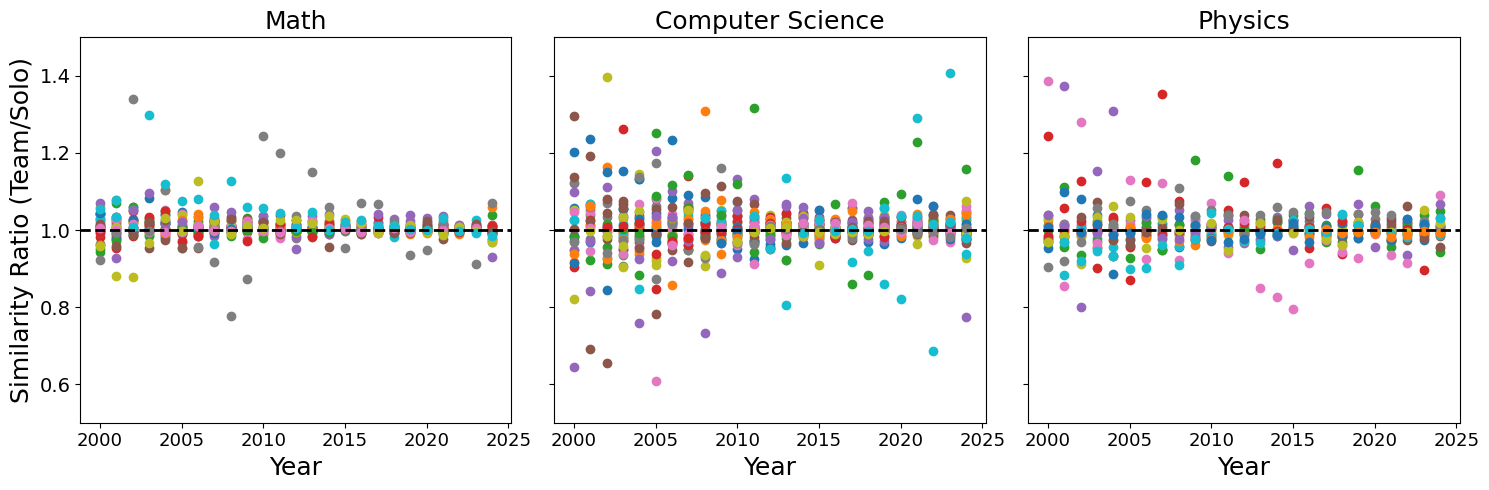

In [ ]:
# create a plot with subplots for each category, same y axis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True)  
y_axis_range = (0.5, 1.5)

plot_ratios(math_ratios, ax1, 'Math', show_y_label = True, y_range = y_axis_range)
plot_ratios(cs_ratios, ax2, 'Computer Science', y_range = y_axis_range)
plot_ratios(physics_ratios, ax3, 'Physics', y_range = y_axis_range)

plt.tight_layout()

plt.show()

### Global Averages

In [ ]:
def calculate_global_averages(cosine_similarities_time):
    global_averages = defaultdict(lambda: defaultdict(list))
    # get cosine similarities from all subcategories
    for subcategory, team_types in cosine_similarities_time.items():
        for team_type, years in team_types.items():
            for year, sims in years.items():
                global_averages[team_type][year].extend(sims)

    # get average for each team type and year
    for team_type, years in global_averages.items():
        for year, sims in years.items():
            global_averages[team_type][year] = np.mean(sims) if sims else None

    return global_averages

math_global_averages = calculate_global_averages(math_cosine_similarities)


In [ ]:
def get_global_ratios(global_averages):
    # get overall ratios for category
    average_ratios = {}

    # get team and solo averages
    team_averages = global_averages.get('team', {})
    solo_averages = global_averages.get('single', {})

    for year in team_averages.keys():
        if year in solo_averages and solo_averages[year] is not None and solo_averages[year] != 0:
            average_ratios[year] = team_averages[year] / solo_averages[year]

    return average_ratios

math_global_ratios = get_global_ratios(math_global_averages)


In [ ]:
cs_global_averages = calculate_global_averages(cs_cosine_similarities)
cs_global_ratios = get_global_ratios(cs_global_averages)

In [ ]:
physics_global_averages = calculate_global_averages(physics_cosine_similarities)
physics_global_ratios = get_global_ratios(physics_global_averages)

In [ ]:
# plot global ratios

def plot_global_ratios(global_ratios, ax, title, show_y_label = False):
    years = sorted(year for year in global_ratios.keys() if year >= 2000)
    ratios = [global_ratios[year] for year in years if year >= 2000]

    ax.plot(years, ratios, marker=None, linestyle='-', color='b')
    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Similarity Ratio (Team/Solo)', fontsize = 18)

    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 14)
    ax.axhline(y=1, color='r', linestyle='--', linewidth=2)






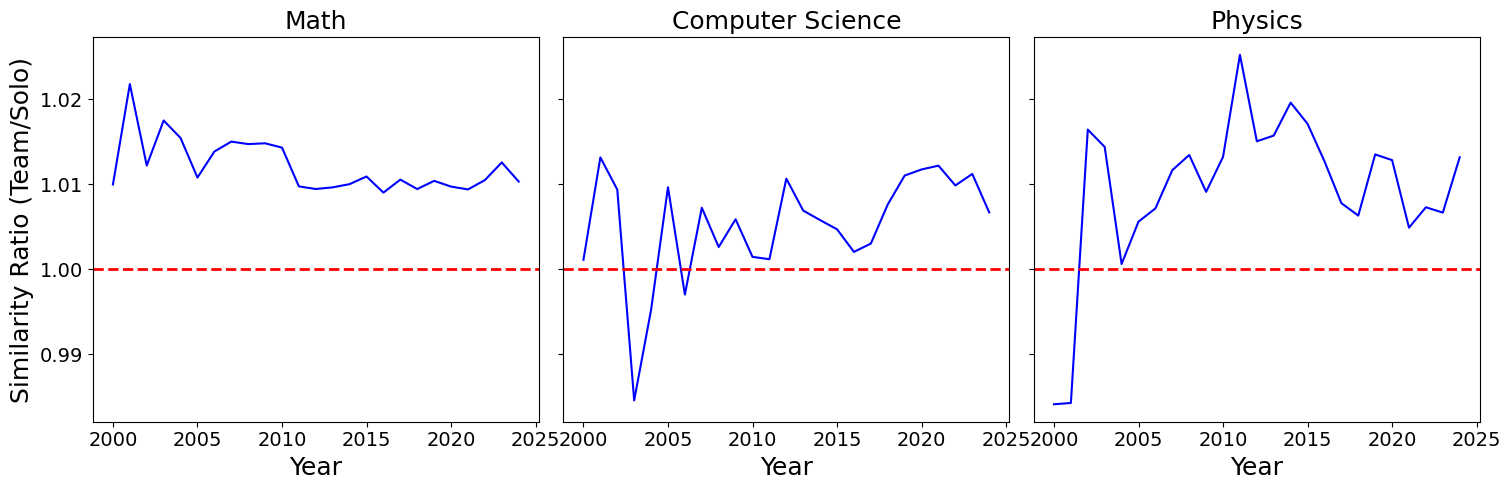

In [ ]:
# plot subplots for each category
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True)  

plot_global_ratios(math_global_ratios, ax1, 'Math', show_y_label = True)
plot_global_ratios(cs_global_ratios, ax2, 'Computer Science')
plot_global_ratios(physics_global_ratios, ax3, 'Physics')

plt.tight_layout()

plt.show()

## Count Data Points

In [ ]:
def count_data_points(cosine_similarities_time):
    data_points_count = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for subcategory, team_types in cosine_similarities_time.items():
        for team_type, years in team_types.items():
            for year, similarities in years.items():
                data_points_count[subcategory][team_type][year] = len(similarities)

    return data_points_count

data_points_count_math = count_data_points(math_cosine_similarities)

for subcategory, team_types in data_points_count.items():
    for team_type, years in team_types.items():
        for year, count in years.items():
            print(f"Subcategory: {subcategory}, Team Type: {team_type}, Year: {year}, Data Points: {count}")


Subcategory: math.CO, Team Type: single, Year: 2007, Data Points: 475
Subcategory: math.CO, Team Type: single, Year: 2008, Data Points: 545
Subcategory: math.CO, Team Type: single, Year: 2009, Data Points: 654
Subcategory: math.CO, Team Type: single, Year: 2010, Data Points: 809
Subcategory: math.CO, Team Type: single, Year: 2011, Data Points: 1012
Subcategory: math.CO, Team Type: single, Year: 2012, Data Points: 1058
Subcategory: math.CO, Team Type: single, Year: 2013, Data Points: 1150
Subcategory: math.CO, Team Type: single, Year: 2014, Data Points: 1290
Subcategory: math.CO, Team Type: single, Year: 2015, Data Points: 1360
Subcategory: math.CO, Team Type: single, Year: 2016, Data Points: 1493
Subcategory: math.CO, Team Type: single, Year: 2017, Data Points: 1529
Subcategory: math.CO, Team Type: single, Year: 2018, Data Points: 1650
Subcategory: math.CO, Team Type: single, Year: 2019, Data Points: 1597
Subcategory: math.CO, Team Type: single, Year: 2020, Data Points: 1769
Subcategor

In [ ]:
data_points_count_cs = count_data_points(cs_cosine_similarities)

data_points_count_physics = count_data_points(physics_cosine_similarities)

In [ ]:
# set default font size
plt.rcParams['font.size'] = 16  

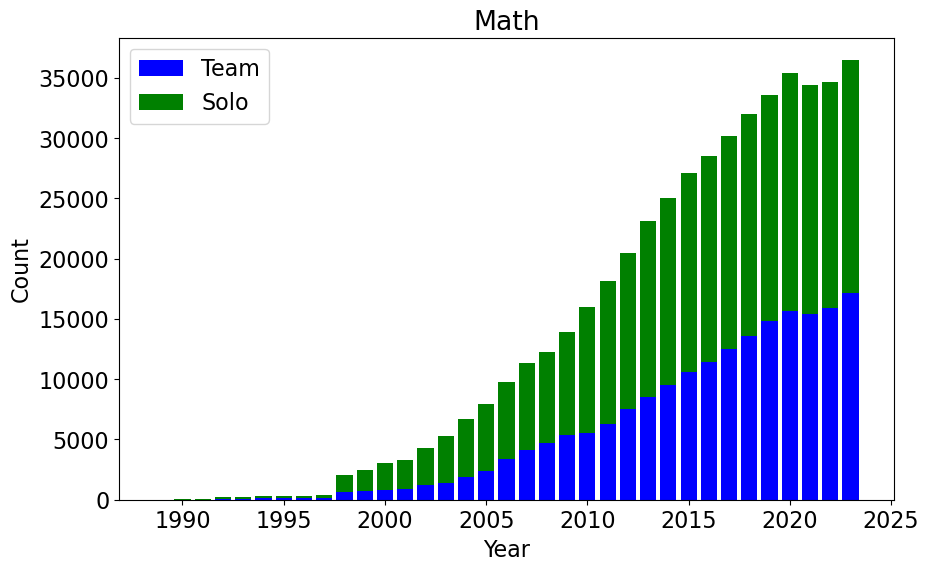

In [ ]:
def aggregate_data_points(data_points_count):
    ''' get number of data points by team type'''
    aggregated_data = defaultdict(lambda: defaultdict(int))  
    for category, team_types in data_points_count.items():
            for team_type, years in team_types.items():
                for year, count in years.items():
                    aggregated_data[year][team_type] += count
    return aggregated_data

aggregated_math_data = aggregate_data_points(data_points_count_math)

# plot counts by team type
def plot_aggregated_data_points_by_team_type(aggregated_data, category_name):
    years = sorted(year for year in aggregated_data.keys() if year < 2024)
    team_counts = [aggregated_data[year]['team'] for year in years]
    solo_counts = [aggregated_data[year]['single'] for year in years]
    
    plt.figure(figsize=(10, 6))
    plt.bar(years, team_counts, color='blue', label='Team')
    plt.bar(years, solo_counts, bottom=team_counts, color='green', label='Solo')
    plt.title(f'{category_name}')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

plot_aggregated_data_points_by_team_type(aggregated_math_data, 'Math')


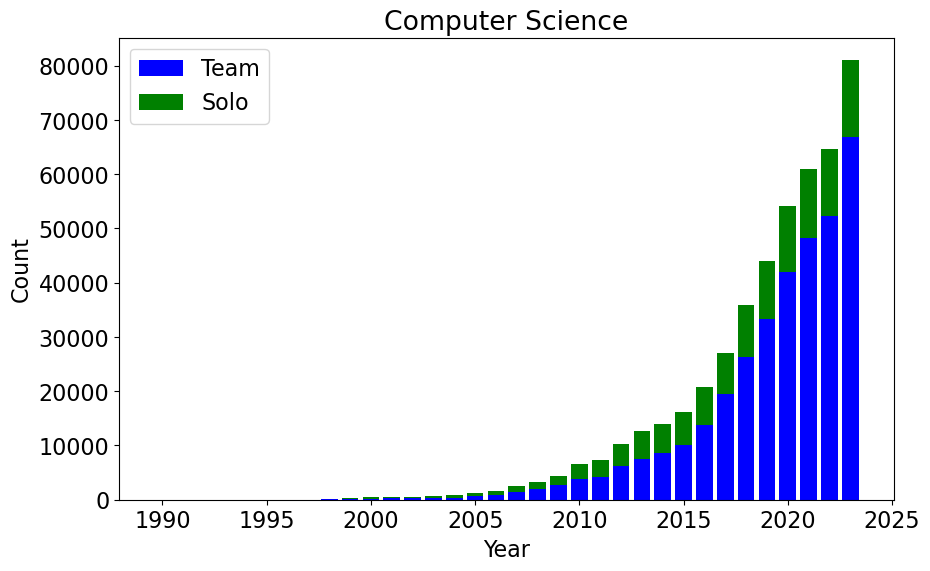

In [ ]:
aggregated_cs_data = aggregate_data_points(data_points_count_cs)

plot_aggregated_data_points_by_team_type(aggregated_cs_data, 'Computer Science')

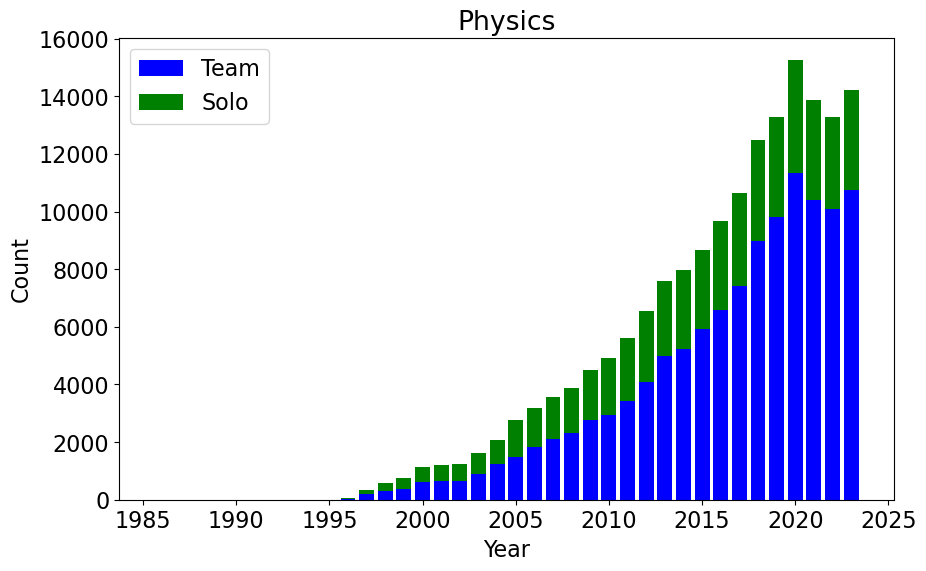

In [ ]:
aggregated_physics_data = aggregate_data_points(data_points_count_physics)

plot_aggregated_data_points_by_team_type(aggregated_physics_data, 'Physics')

# Team Sizes

In [ ]:
def extract_team_sizes(data, categories):
    """
    Get team size by year and category. 
    Returns dictionary of form {category: year: [team_sizes]}.
    """
    team_sizes_by_category = defaultdict(lambda: defaultdict(list))

    for item in data:
        year = item['creation_year']
        team_size = item['team_size']
        category = item['main_category']

        team_sizes_by_category[category][year].append(team_size)
    
    return team_sizes_by_category

In [ ]:
team_sizes_by_category = defaultdict(defaultdict_list)
for item in data_subset:
    year = item['creation_year']
    team_size = item['team_size']
    category = item['main_category']
    team_sizes_by_category[category][year].append(team_size)

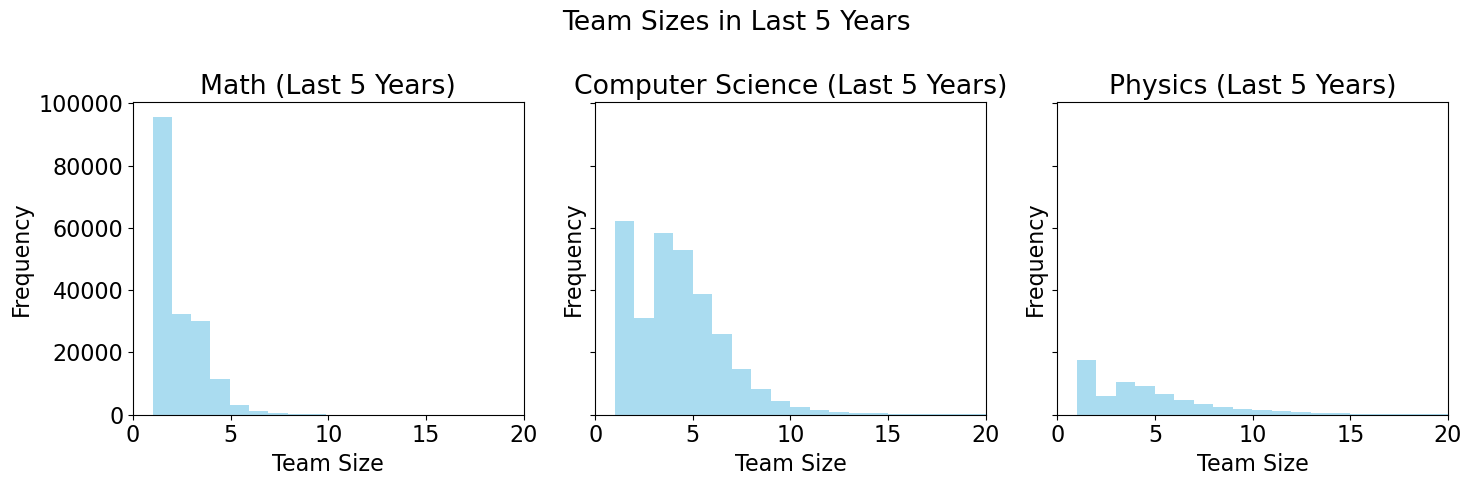

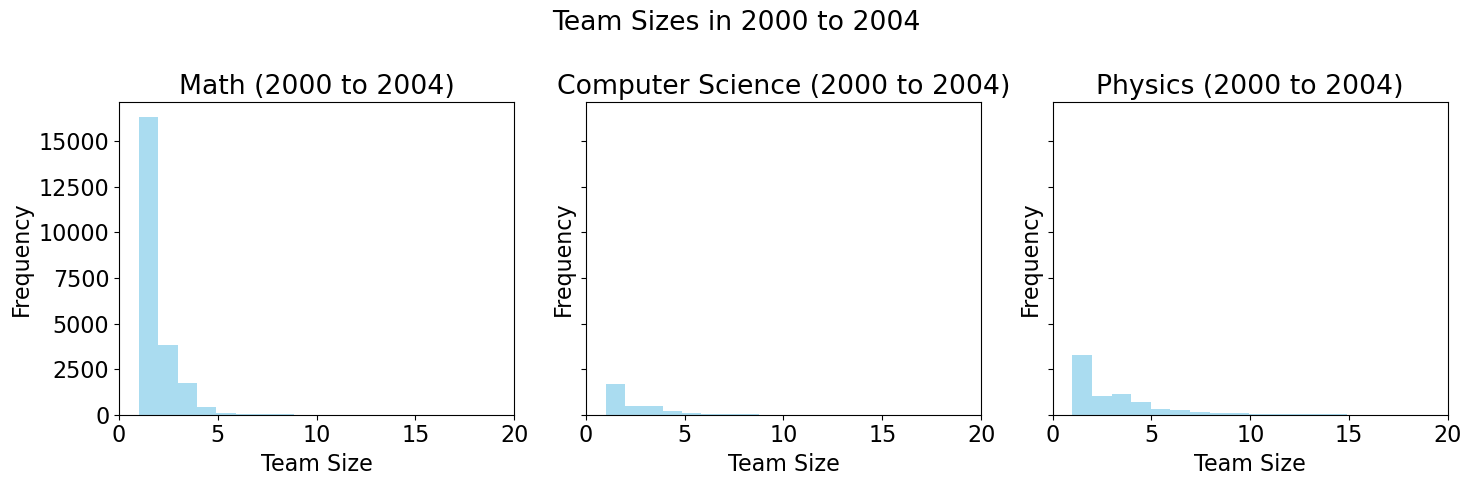

In [ ]:
# plot histograms of team sizes in first and last five years
def get_histogram_data(team_sizes_by_category, start_year, end_year):
    histogram_data = defaultdict(list)
    for category, years in team_sizes_by_category.items():
        for year, team_sizes in years.items():
            if start_year <= year <= end_year:
                histogram_data[category].extend(team_sizes)
    return histogram_data

recent_start_year = 2019
early_start_year = 2000
early_end_year = 2004

recent_histogram_data = get_histogram_data(team_sizes_by_category, recent_start_year, recent_start_year + 4)
early_histogram_data = get_histogram_data(team_sizes_by_category, early_start_year, early_end_year)

def plot_histograms(histogram_data, period_description):
    num_categories = len(histogram_data)
    fig, axes = plt.subplots(1, num_categories, figsize=(5 * num_categories, 5), sharey=True)
    fig.suptitle(f'Team Sizes in {period_description}')

    categories = ['math', 'cs','physics']
    category_map = {'math': 'Math', 'cs': 'Computer Science', 'physics': 'Physics'}
    
    for ax, category in zip(axes, categories):
        data = histogram_data.get(category, [])
        ax.hist(data, bins=max(data) - min(data) + 1, color='skyblue', alpha=0.7)
        ax.set_title(f'{category_map[category]} ({period_description})')
        ax.set_xlabel('Team Size')
        ax.set_ylabel('Frequency')
        ax.set_xlim(0, 20)  # limit x axis

    plt.tight_layout()
    plt.show()

plot_histograms(recent_histogram_data, 'Last 5 Years')
plot_histograms(early_histogram_data, '2000 to 2004')


### Plot team sizes over time

In [ ]:
def calculate_average_team_sizes(team_sizes_by_category):
    average_team_sizes_by_category = defaultdict(dict)
    for category, sizes_by_year in team_sizes_by_category.items():
        for year, sizes in sizes_by_year.items():
            average_team_sizes_by_category[category][year] = sum(sizes) / len(sizes)
    
    return average_team_sizes_by_category

In [ ]:
cat_avg_team_sizes = calculate_average_team_sizes(team_sizes_by_category)

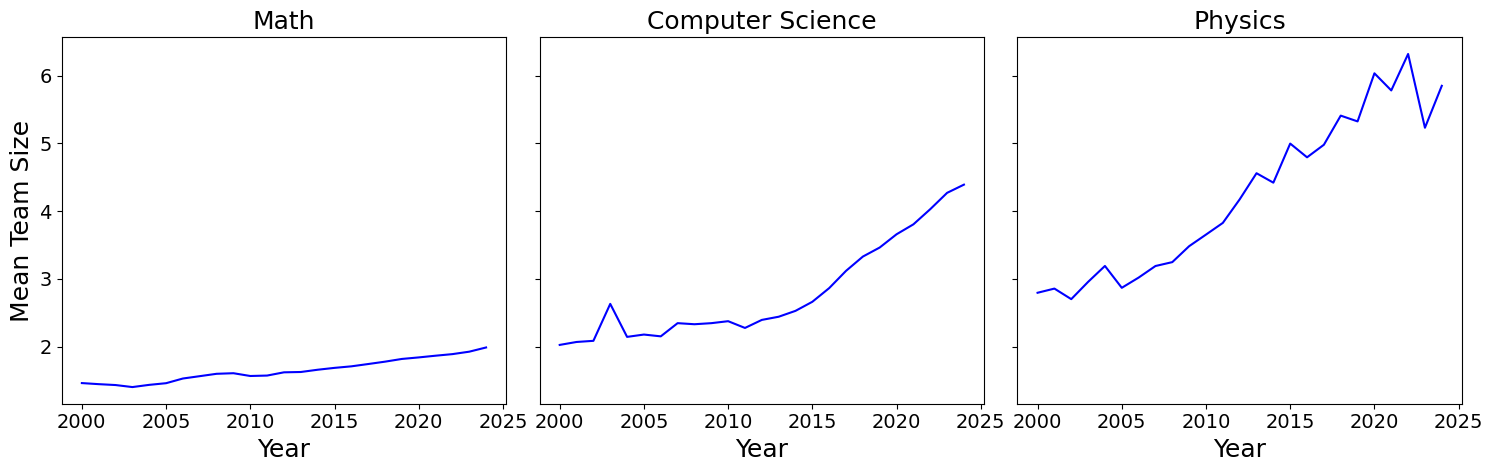

In [ ]:
def plot_category_data(category, cat_avg_team_sizes, ax, title, show_y_label = False):
    years = sorted(year for year in cat_avg_team_sizes[category].keys() if year >= 2000)
    averages = [cat_avg_team_sizes[category][year] for year in years]
    # plot averages by year
    ax.plot(years, averages, marker=None, linestyle='-', color='b')
    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Mean Team Size', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 14)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True) 

plot_category_data('math', cat_avg_team_sizes, ax1, 'Math', show_y_label = True)
plot_category_data('cs', cat_avg_team_sizes, ax2, 'Computer Science')
plot_category_data('physics', cat_avg_team_sizes, ax3, 'Physics')

plt.tight_layout()

plt.show()

# Small, Medium, Large Teams

In [ ]:
def get_subcat_year_vectors(data, id_to_vector):

    # map team size type
    team_size_to_type = {
        1: 'single', 
        2: 'small_team', 3: 'small_team', 4: 'small_team', 5: 'small_team',
        6: 'medium_team', 7: 'medium_team', 8: 'medium_team', 9: 'medium_team', 10: 'medium_team',
    }

    def get_team_type(size):
        if size >= 11:
            return 'large_team'
        return team_size_to_type.get(size)

    subcat_year_vectors = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    subcat_team_type_vectors = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
    subcat_team_size_vectors = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

    for title_info in tqdm(data):
        title_id = title_info['id']
        main_category = title_info['main_category']
        subcategory = title_info['main_subcategory']
        year = title_info['creation_year']
        team_size = title_info['team_size']

        if team_size == 0:
            continue

        team_type = get_team_type(team_size)

        try:
            title_vector = id_to_vector[title_id]
        except KeyError:
            continue 

        subcat_year_vectors[main_category][subcategory][year].append(title_vector)
        subcat_team_type_vectors[main_category][subcategory][team_type][year].append(title_vector)
        subcat_team_size_vectors[main_category][subcategory][team_size][year].append(title_vector)

    return subcat_year_vectors, subcat_team_type_vectors, subcat_team_size_vectors

In [ ]:
subcat_year_vectors, subcat_team_type_vectors, subcat_team_size_vectors = get_subcat_year_vectors(data_subset, id_to_vector)

100%|██████████| 1142849/1142849 [04:07<00:00, 4612.81it/s]


In [ ]:
math_cosine_similarities = get_cosine_similarities_time('math', subcat_team_type_vectors, cumulative_subcat_centroids)

In [ ]:
cs_cosine_similarities = get_cosine_similarities_time('cs', subcat_team_type_vectors, cumulative_subcat_centroids)

100%|██████████| 40/40 [04:46<00:00,  7.16s/it]


In [ ]:
physics_cosine_similarities = get_cosine_similarities_time('physics', subcat_team_type_vectors, cumulative_subcat_centroids)

100%|██████████| 22/22 [00:29<00:00,  1.34s/it]


## Small

In [ ]:
def get_ratios(average_similarities, team_type):
    ''' get ratio of team to individual cosine similarities 
    returns dictionary ratios[subcategory][year] = ratio'''
    ratios = defaultdict(lambda: defaultdict(float))
    for subcategory, team_types in average_similarities.items():
        for year in team_types[team_type]:
            if year in team_types['single'] and team_types['single'][year] != 0:
                # get avg similarity for team and solo
                team_avg = team_types[team_type][year]
                solo_avg = team_types['single'][year]
                # get ratio
                ratios[subcategory][year] = team_avg / solo_avg
    return ratios


In [ ]:
math_ratios = get_ratios(math_avg_similarities, 'small_team')

In [ ]:
cs_ratios = get_ratios(cs_avg_similarities, 'small_team')

In [ ]:
physics_ratios = get_ratios(physics_avg_similarities, 'small_team')

In [ ]:
import matplotlib.pyplot as plt

def plot_ratios(ratios, ax, title, show_y_label = False, y_range = None):

    for subcategory, years in ratios.items():
        years_list = sorted(year for year in years.keys() if year >= 2000)
        ratio_list = [years[year] for year in years_list if years[year] is not None]

        ax.scatter(years_list, ratio_list, label=subcategory)

    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Similarity Ratio (Small Team/Solo)', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 13)
    # add line at 1.0
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)
    if y_range:
        ax.set_ylim(y_range)


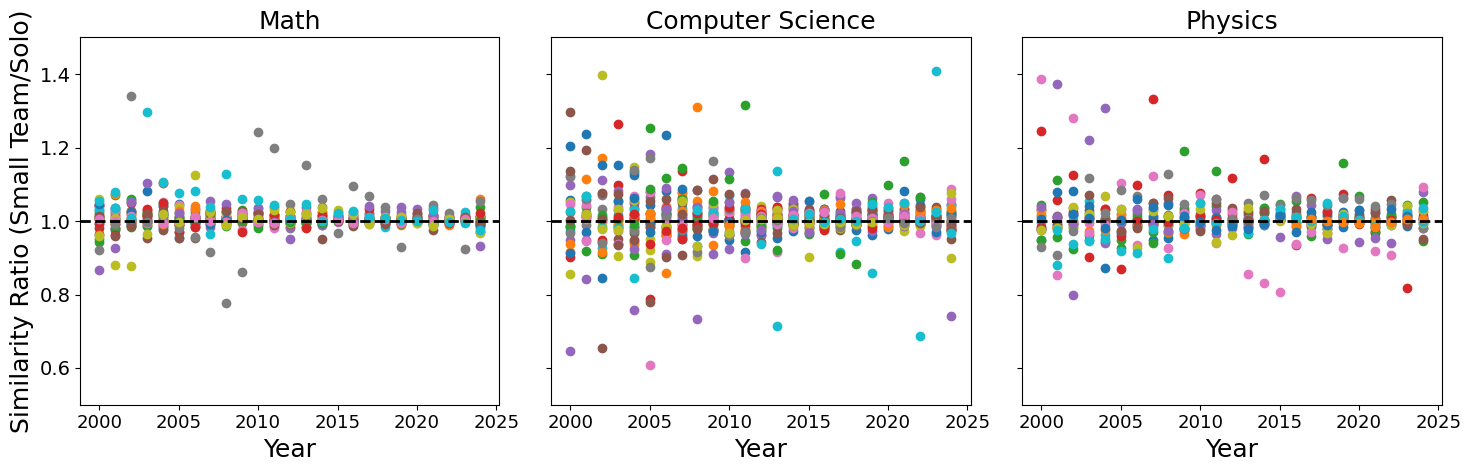

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True)  
y_axis_range = (0.5, 1.5)

plot_ratios(math_ratios, ax1, 'Math', show_y_label = True, y_range = y_axis_range)
plot_ratios(cs_ratios, ax2, 'Computer Science', y_range = y_axis_range)
plot_ratios(physics_ratios, ax3, 'Physics', y_range = y_axis_range)

plt.tight_layout()

plt.show()

## Medium size teams

In [ ]:
math_ratios_medium = get_ratios(math_avg_similarities, 'medium_team')

In [ ]:
cs_ratios_medium = get_ratios(cs_avg_similarities, 'medium_team')

In [ ]:
physics_ratios_medium = get_ratios(physics_avg_similarities, 'medium_team')

In [ ]:
import matplotlib.pyplot as plt

def plot_ratios(ratios, ax, title, show_y_label = False, y_range = None):

    for subcategory, years in ratios.items():
        years_list = sorted(year for year in years.keys() if year >= 2000)
        ratio_list = [years[year] for year in years_list if years[year] is not None]

        ax.scatter(years_list, ratio_list, label=subcategory)

    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Similarity Ratio (Medium Team/Solo)', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 13)
    # add line at 1.0
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)
    if y_range:
        ax.set_ylim(y_range)


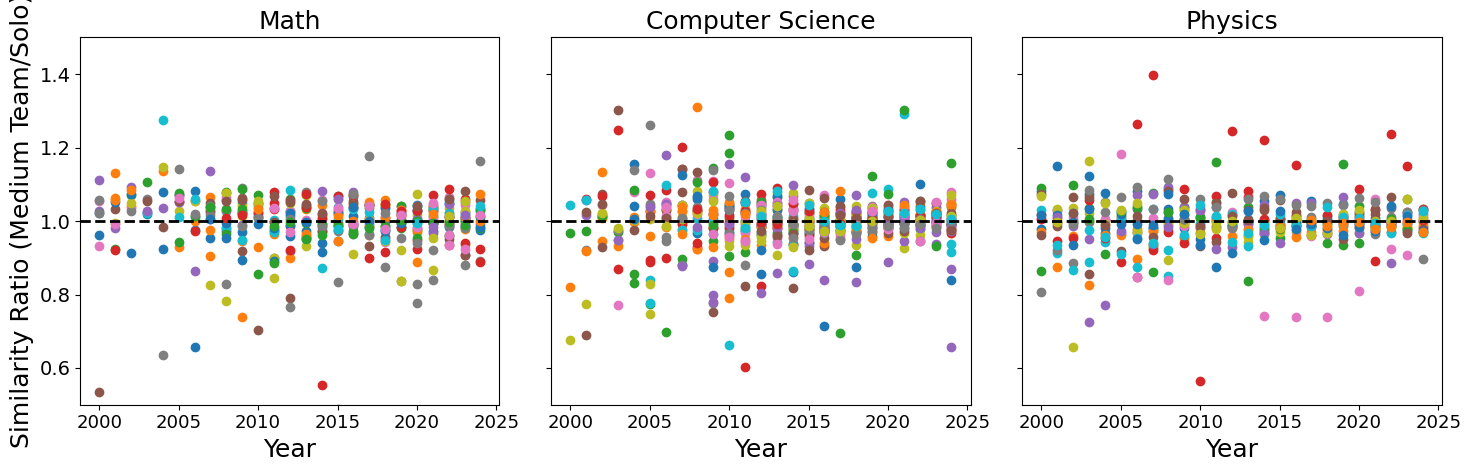

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True)  
y_axis_range = (0.5, 1.5)

plot_ratios(math_ratios_medium, ax1, 'Math', show_y_label = True, y_range = y_axis_range)
plot_ratios(cs_ratios_medium, ax2, 'Computer Science', y_range = y_axis_range)
plot_ratios(physics_ratios_medium, ax3, 'Physics', y_range = y_axis_range)

plt.tight_layout()

plt.show()

## Large teams

In [ ]:
math_ratios_large = get_ratios(math_avg_similarities, 'large_team')
cs_ratios_large = get_ratios(cs_avg_similarities, 'large_team')
physics_ratios_large = get_ratios(physics_avg_similarities, 'large_team')

In [ ]:
import matplotlib.pyplot as plt

def plot_ratios(ratios, ax, title, show_y_label = False, y_range = None):

    for subcategory, years in ratios.items():
        years_list = sorted(year for year in years.keys() if year >= 2000)
        ratio_list = [years[year] for year in years_list if years[year] is not None]

        ax.scatter(years_list, ratio_list, label=subcategory)

    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Similarity Ratio (Large Team/Solo)', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 13)
    # add line at 1.0
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)
    if y_range:
        ax.set_ylim(y_range)


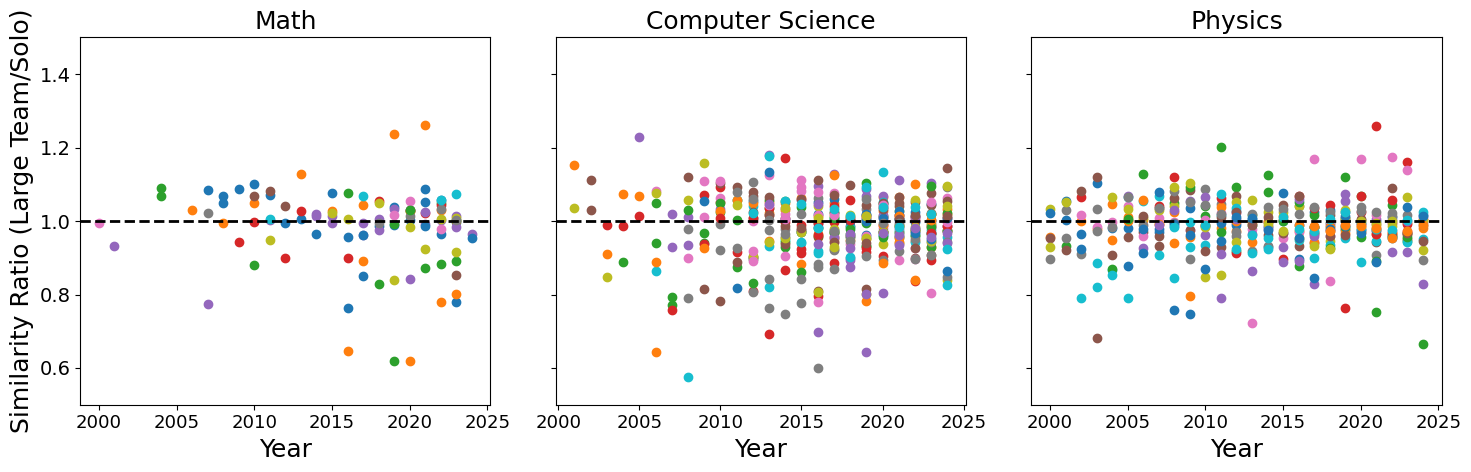

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True)  
y_axis_range = (0.5, 1.5)

plot_ratios(math_ratios_large, ax1, 'Math', show_y_label = True, y_range = y_axis_range)
plot_ratios(cs_ratios_large, ax2, 'Computer Science', y_range = y_axis_range)
plot_ratios(physics_ratios_large, ax3, 'Physics', y_range = y_axis_range)

plt.tight_layout()

plt.show()

## Global Averages

In [ ]:
def calculate_global_averages(cosine_similarities_time):
    global_averages = defaultdict(lambda: defaultdict(list))
    # get cosine similarities from all subcategories
    for subcategory, team_types in cosine_similarities_time.items():
        for team_type, years in team_types.items():
            for year, sims in years.items():
                global_averages[team_type][year].extend(sims)

    # get average for each team type and year
    for team_type, years in global_averages.items():
        for year, sims in years.items():
            global_averages[team_type][year] = np.mean(sims) if sims else None

    return global_averages

math_global_averages = calculate_global_averages(math_cosine_similarities)


In [ ]:
def get_global_ratios(global_averages, team_type):
    # get overall ratios for category
    average_ratios = {}

    # get team and solo averages
    team_averages = global_averages.get(team_type, {})
    solo_averages = global_averages.get('single', {})

    for year in team_averages.keys():
        if year in solo_averages and solo_averages[year] is not None and solo_averages[year] != 0:
            average_ratios[year] = team_averages[year] / solo_averages[year]

    return average_ratios

math_global_ratios = get_global_ratios(math_global_averages, 'small_team')


In [ ]:
cs_global_averages = calculate_global_averages(cs_cosine_similarities)
physics_global_averages = calculate_global_averages(physics_cosine_similarities)


In [ ]:
# plot global ratios

def plot_global_ratios(global_ratios, ax, title, show_y_label = False):
    years = sorted(year for year in global_ratios.keys() if year >= 2000)
    ratios = [global_ratios[year] for year in years if year >= 2000]

    ax.plot(years, ratios, marker=None, linestyle='-', color='b')
    ax.set_title(title, fontsize = 18)
    ax.set_xlabel('Year', fontsize = 18)
    if show_y_label:
        ax.set_ylabel('Similarity Ratio', fontsize = 18)

    ax.tick_params(axis = 'y', labelsize = 14)
    ax.tick_params(axis = 'x', labelsize = 14)
    ax.axhline(y=1, color='r', linestyle='--', linewidth=2)





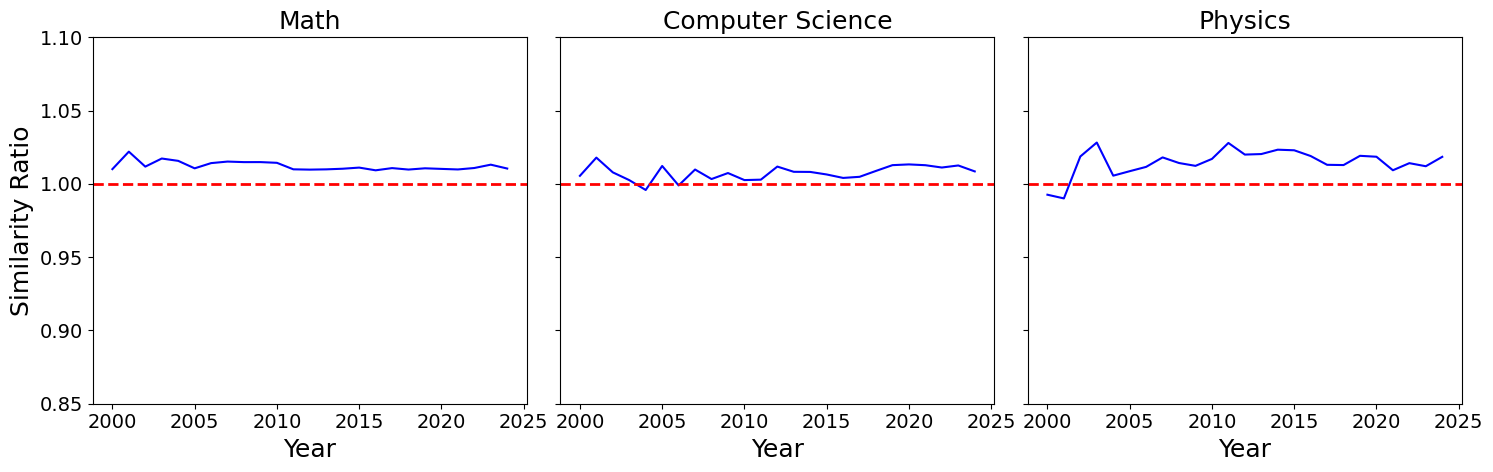

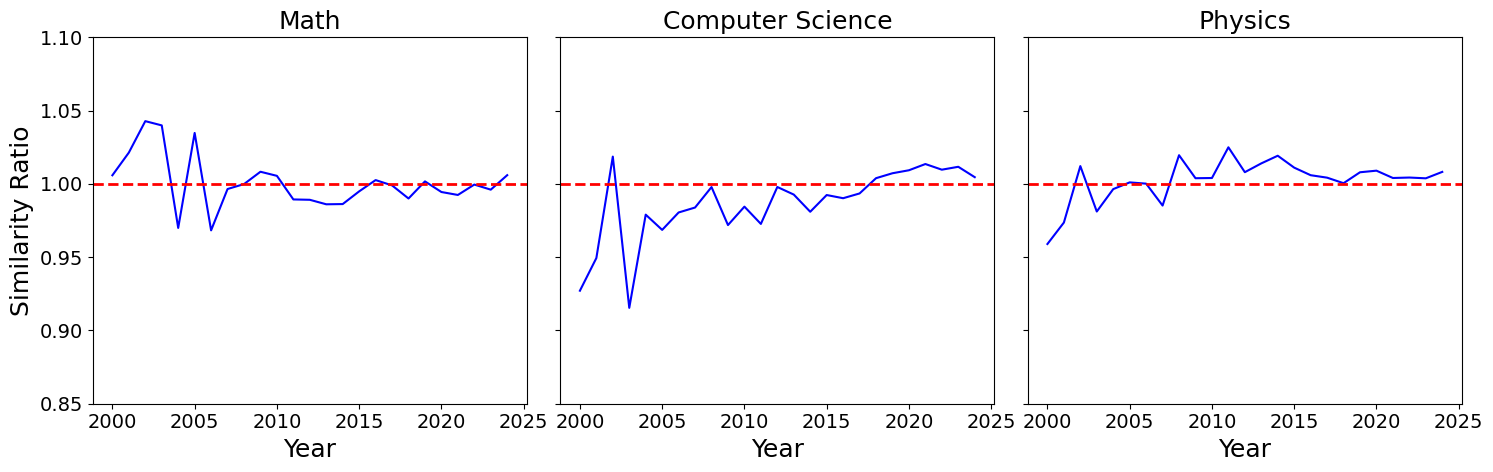

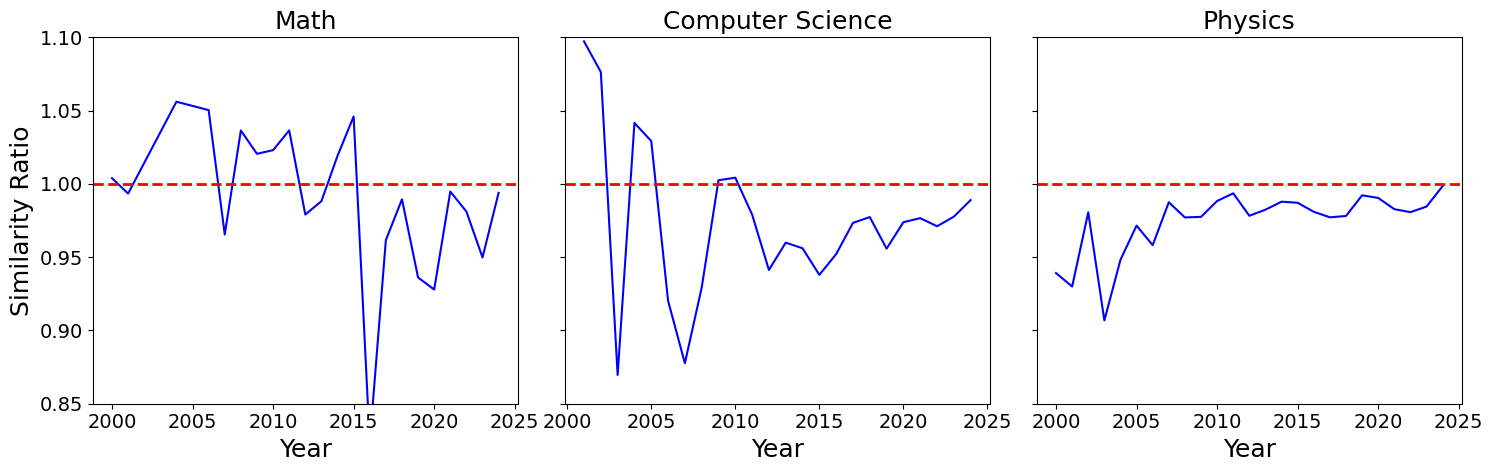

In [ ]:
for team_size in ['small_team', 'medium_team', 'large_team']:
    cs_global_ratios = get_global_ratios(cs_global_averages, team_size)
    physics_global_ratios = get_global_ratios(physics_global_averages, team_size)
    math_global_ratios = get_global_ratios(math_global_averages, team_size)
    # subplots for each category
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey = True)  

    plot_global_ratios(math_global_ratios, ax1, 'Math', show_y_label = True)
    plot_global_ratios(cs_global_ratios, ax2, 'Computer Science')
    plot_global_ratios(physics_global_ratios, ax3, 'Physics')

    # use same y axis
    y_min = 0.85
    y_max = 1.1

    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)
    ax3.set_ylim(y_min, y_max)
    plt.tight_layout()

    plt.show()

# Get Distribution

In [ ]:
# get all similarities
all_similarities_math = []

for subcategory in math_cosine_similarities:
    for team_type in math_cosine_similarities[subcategory]:
        for year in math_cosine_similarities[subcategory][team_type]:
            if year >= 2019: 
                all_similarities_math.extend(math_cosine_similarities[subcategory][team_type][year])

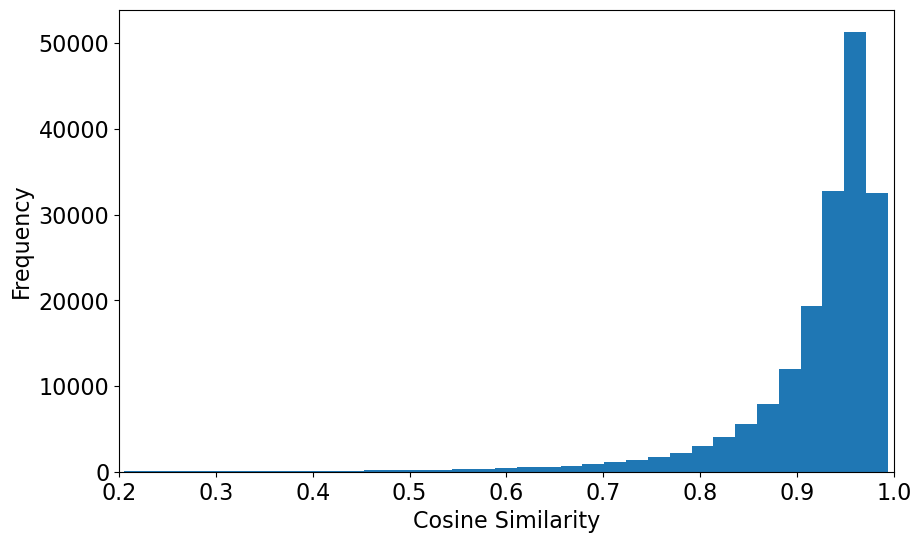

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(all_similarities_math, bins=50,)
plt.xlabel('Cosine Similarity')
plt.xlim(0.2, 1.0)
plt.ylabel('Frequency')
plt.savefig('math_similarities_dist.png')
plt.show()


In [ ]:
all_similarities_cs = []

for subcategory in cs_cosine_similarities:
    for team_type in cs_cosine_similarities[subcategory]:
        for year in cs_cosine_similarities[subcategory][team_type]:
            if year >= 2019: 
                all_similarities_cs.extend(cs_cosine_similarities[subcategory][team_type][year])



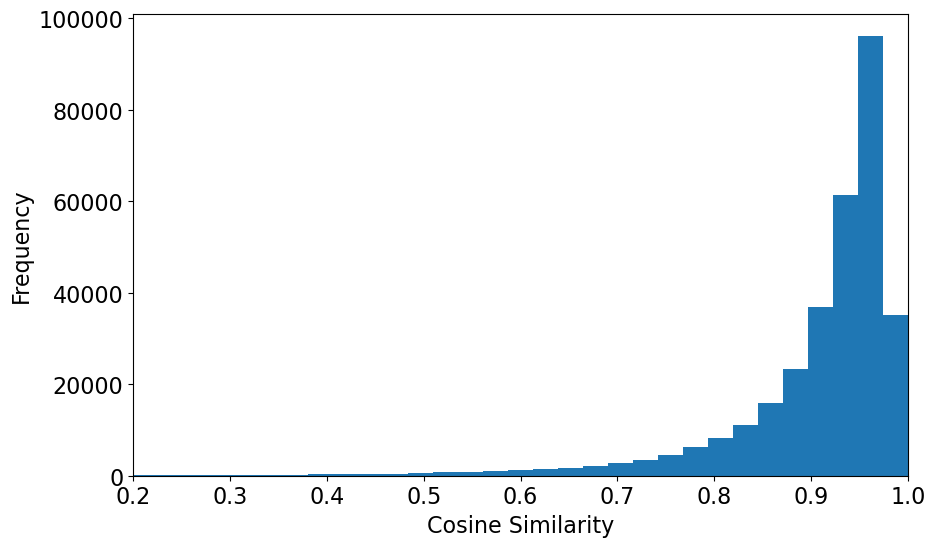

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_similarities_cs, bins=50,)
plt.xlabel('Cosine Similarity')
plt.xlim(0.2, 1.0)
plt.ylabel('Frequency')
plt.savefig('cs_similarities_dist.png')
plt.show()


In [ ]:
all_similarities_physics = []

for subcategory in physics_cosine_similarities:
    for team_type in physics_cosine_similarities[subcategory]:
        for year in physics_cosine_similarities[subcategory][team_type]:
            if year >= 2019:  
                all_similarities_physics.extend(physics_cosine_similarities[subcategory][team_type][year])



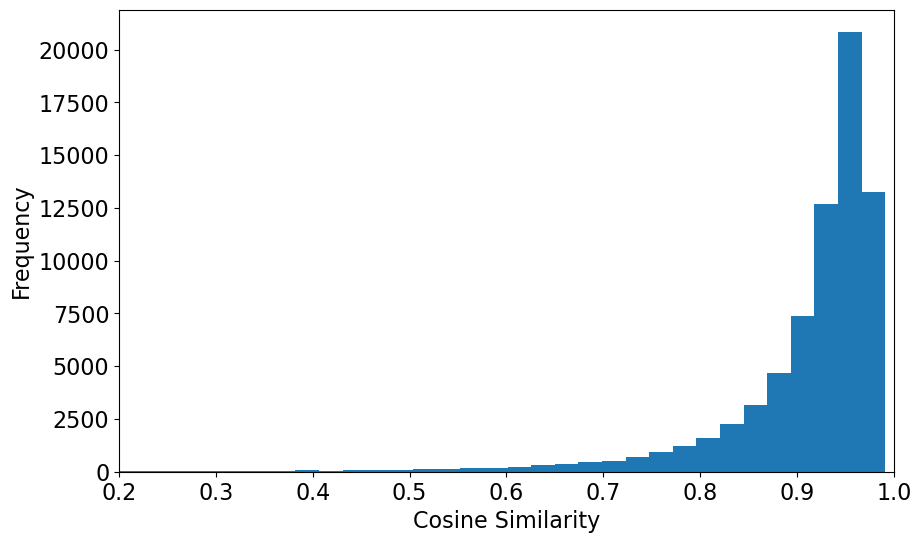

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_similarities_physics, bins=50,)
plt.xlabel('Cosine Similarity')
plt.xlim(0.2, 1.0)
plt.ylabel('Frequency')
plt.savefig('physics_similarities_dist.png')
plt.show()


# First 5 Years

In [ ]:
# get all similarities
all_similarities_math = []

for subcategory in math_cosine_similarities:
    for team_type in math_cosine_similarities[subcategory]:
        for year in math_cosine_similarities[subcategory][team_type]:
            if 2000 <= year <= 2004: 
                all_similarities_math.extend(math_cosine_similarities[subcategory][team_type][year])

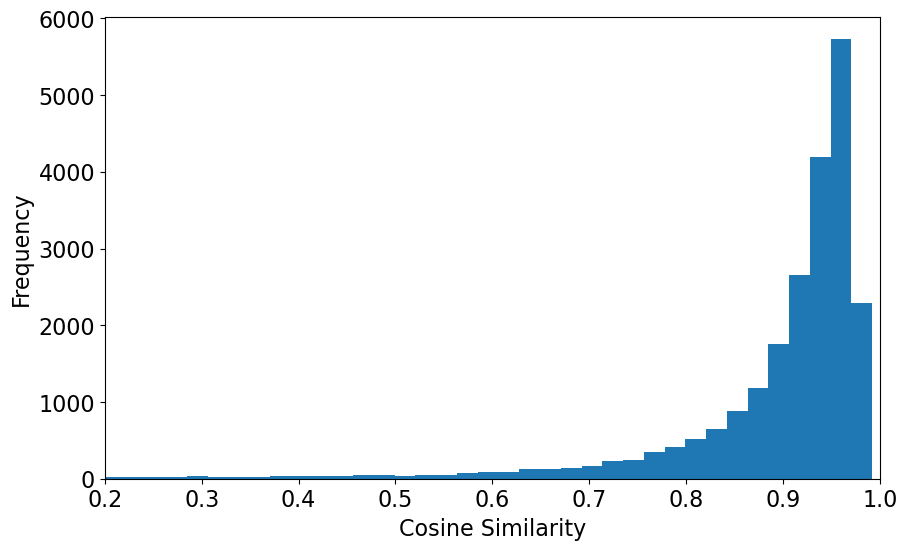

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(all_similarities_math, bins=50,)
plt.xlabel('Cosine Similarity')
plt.xlim(0.2, 1.0)
plt.ylabel('Frequency')
plt.savefig('math_similarities_dist.png')
plt.show()


In [ ]:
all_similarities_cs = []

for subcategory in cs_cosine_similarities:
    for team_type in cs_cosine_similarities[subcategory]:
        for year in cs_cosine_similarities[subcategory][team_type]:
            if 2000 <= year <= 2004: 
                all_similarities_cs.extend(cs_cosine_similarities[subcategory][team_type][year])



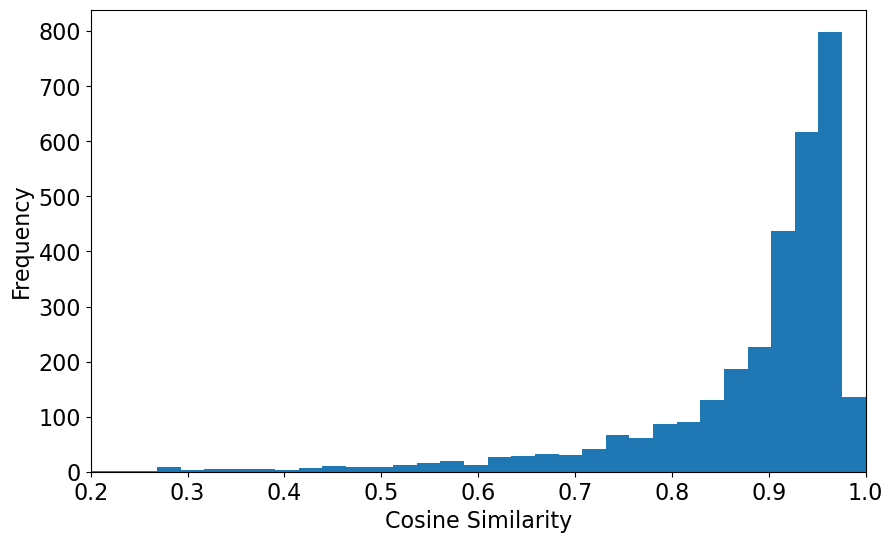

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_similarities_cs, bins=50,)
plt.xlabel('Cosine Similarity')
plt.xlim(0.2, 1.0)
plt.ylabel('Frequency')
plt.savefig('cs_similarities_dist.png')
plt.show()


In [ ]:
all_similarities_physics = []

for subcategory in physics_cosine_similarities:
    for team_type in physics_cosine_similarities[subcategory]:
        for year in physics_cosine_similarities[subcategory][team_type]:
            if 2000 <= year <= 2004:  
                all_similarities_physics.extend(physics_cosine_similarities[subcategory][team_type][year])



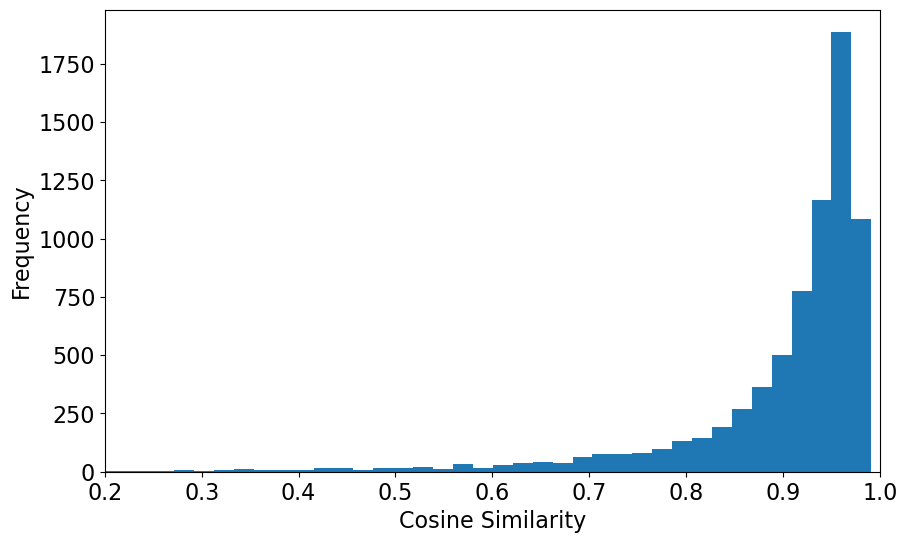

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_similarities_physics, bins=50,)
plt.xlabel('Cosine Similarity')
plt.xlim(0.2, 1.0)
plt.ylabel('Frequency')
plt.savefig('physics_similarities_dist.png')
plt.show()
